In [13]:
from skimage import morphology as mo
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from skimage.morphology import skeletonize , medial_axis
from skimage.util import invert
from scipy import ndimage as ndi
import cv2 as cv
from scipy.ndimage import convolve
import yaml
import networkx as nx
import matplotlib.pyplot as plt


In [14]:
# version chat gpt
import numpy as np
from scipy.ndimage import label, center_of_mass

def chebyshev_distance(p1, p2):
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))

def separarDT(image, k):
    binary_image = (image > 0).astype(np.uint8)  # Convertir a binario
    labeled, num_features = label(binary_image)  # Etiquetar componentes conectados
    
    pixel_groups = []
    trifurcacion = []
    for i in range(1, num_features + 1):
        pixels = np.column_stack(np.where(labeled == i))  # Extraer píxeles del componente
        merged = False
        
        for group in pixel_groups:
            if any(chebyshev_distance(p, pixels[0]) <= k for p in group):
                group.extend(pixels.tolist())
                merged = True
                break
        
        if not merged:
            pixel_groups.append(pixels.tolist())
   
    new_image = np.zeros_like(image)
    new_image2 = np.zeros_like(image)
    for group in pixel_groups:
        if len(group) > 1:
            centroid = np.round(np.mean(group, axis=0)).astype(int)
            new_image[tuple(centroid)] = 255  # Marcar píxel blanco
        else:
            new_image2[tuple(group[0])] = 255  # Marcar píxel blanco
    
    return new_image, new_image2




In [21]:
S1 = np.array((
        [ 0,-1, 0],
        [ 1, 1, 1],
        [-1, 1,-1]), dtype="int")
S2 = np.array((
        [0, -1, 1],
        [1, 1, -1],
        [-1, 1, 0]), dtype="int")

S3 = np.array((
        [ 0,-1, 1],
        [ 1, 1,-1],
        [ 0,-1, 1]), dtype="int") 
S4 = np.array((
        [-1,-1, 1],
        [-1, 1,-1],
        [ 1,-1, 1]), dtype="int") 
S1f = np.array((
        [-1,-1,-1],
        [ 1, 1,-1],
        [-1,-1,-1]), dtype="int")
S2f = np.array((
        [-1,-1, 1],
        [-1, 1,-1],
        [-1,-1,-1]), dtype="int")
se3  = mo.rectangle(5,5)
def detector(I,S):
    I = I.astype(np.uint8)
    H = I[:,:] *0
    for i in range(4):
        S = np.rot90(S)
        H = H + cv.morphologyEx(I, cv.MORPH_HITMISS, S)
    return H
        

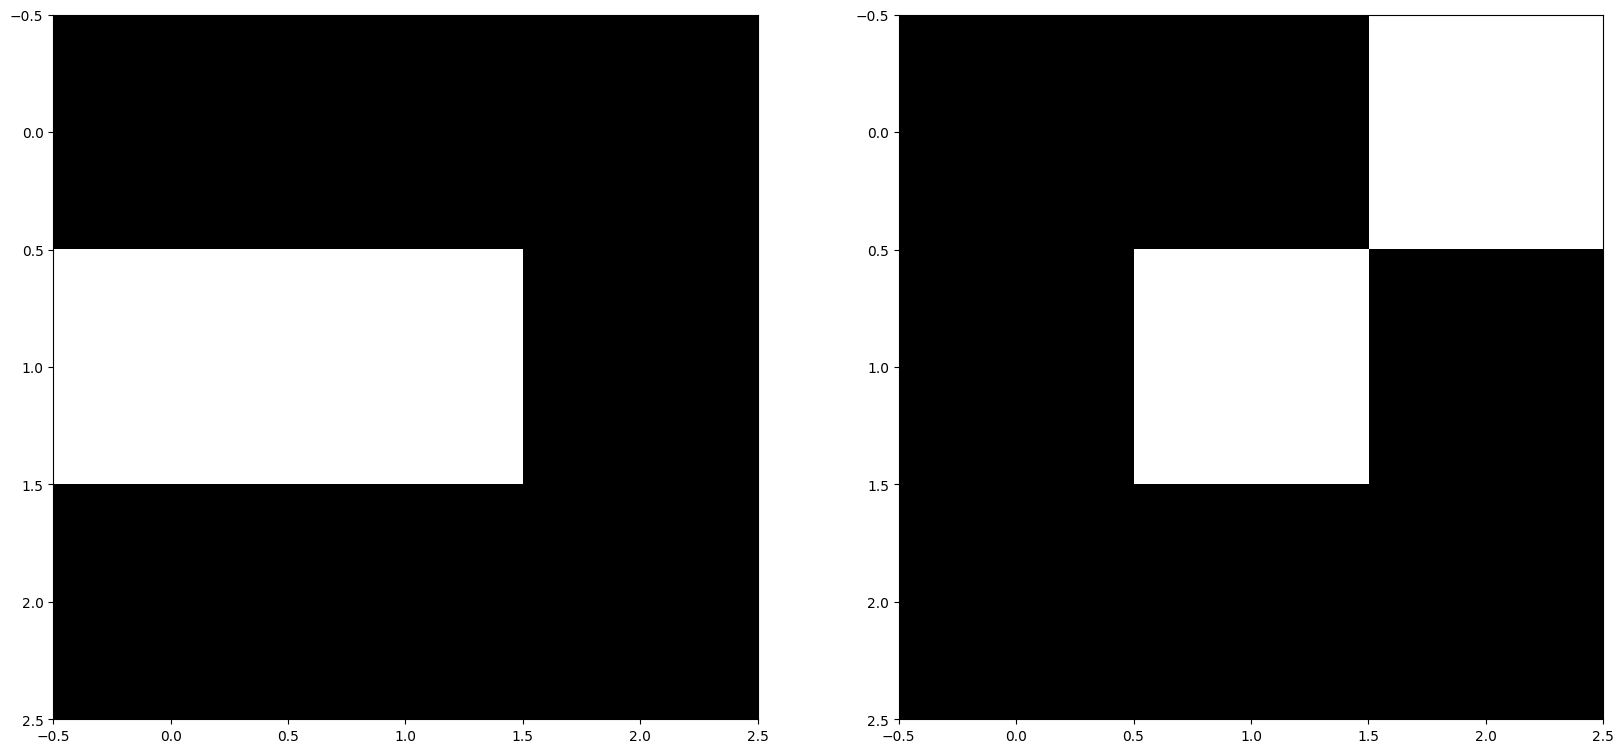

In [22]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1) 
plt.imshow(S1f,cmap='gray', vmin=-1, vmax=1)
plt.subplot(1,2,2)                                 
plt.imshow(S2f,cmap='gray', vmin=-1, vmax=1)
plt.show()

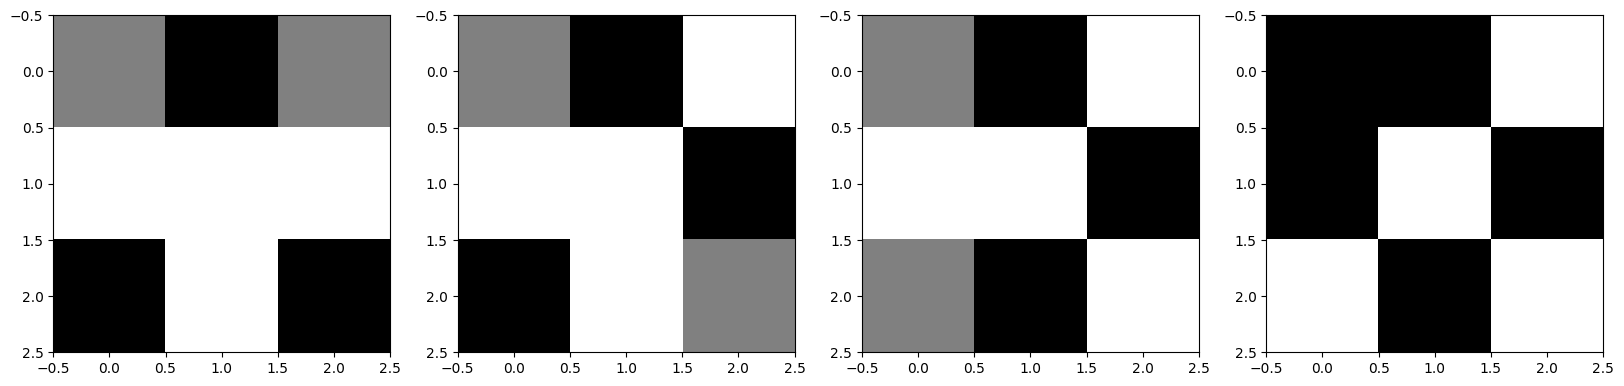

In [23]:
plt.figure(figsize=(20,20))
plt.subplot(1,4,1) 
plt.imshow(S1,cmap='gray', vmin=-1, vmax=1)
plt.subplot(1,4,2)                                 
plt.imshow(S2,cmap='gray', vmin=-1, vmax=1)
plt.subplot(1,4,3)                                 
plt.imshow(S3,cmap='gray', vmin=-1, vmax=1)
plt.subplot(1,4,4)                                 
plt.imshow(S4,cmap='gray', vmin=-1, vmax=1)
plt.show()

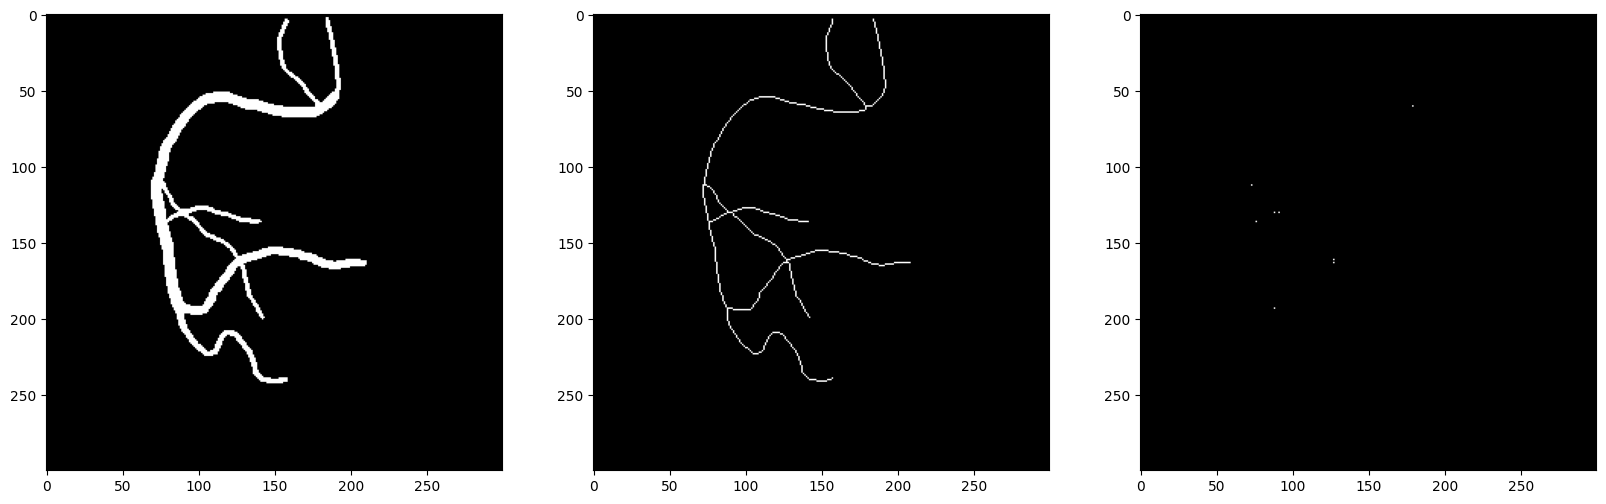

[[ 60 179]
 [112  73]
 [130  88]
 [130  91]
 [136  76]
 [161 127]
 [163 127]
 [193  88]]


In [24]:
I = plt.imread('database/1_gt.pgm')
I = I/255

#I = (ski.color.rgb2gray(I* 255)).astype(np.uint8)
T = skeletonize(I)
# Supongamos que R, G y B son imágenes en escala de grises con el mismo tamaño
R0 = detector(T,S1) + detector(T,S2) + detector(T,S3) + detector(T,S4) # Canal Rojo
plt.figure(figsize=(20,20))
plt.subplot(1,3,1) 
plt.imshow(I,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,3,2)                                 
plt.imshow(T,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,3,3)                                 
plt.imshow(R0,cmap='gray', vmin=0, vmax=1)
plt.show()
print(np.argwhere(R0 > 0))

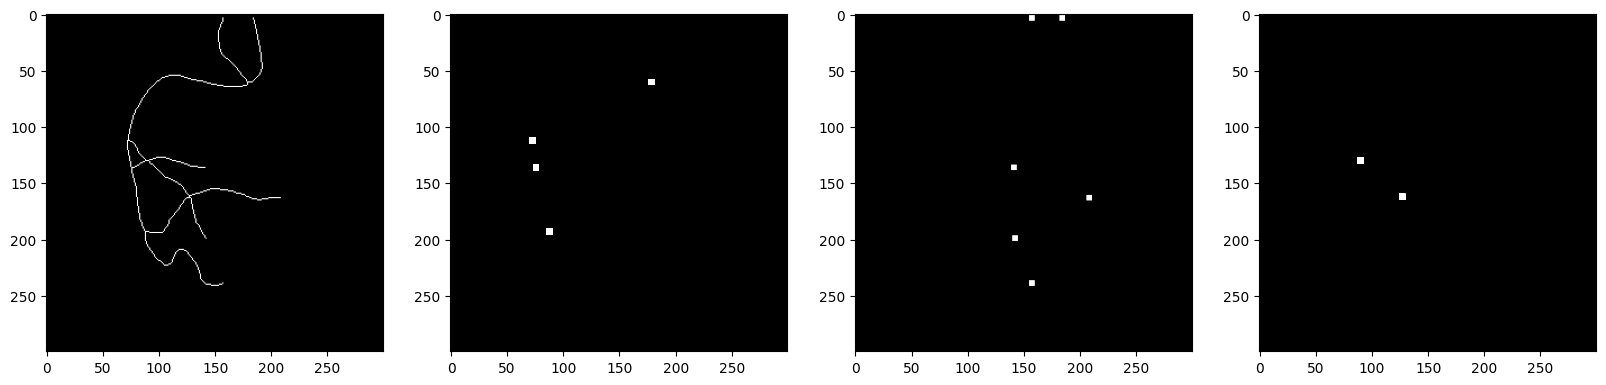

In [28]:
I = plt.imread('database/1_gt.pgm')
I = I/255
#I = (ski.color.rgb2gray(I* 255)).astype(np.uint8)
T = skeletonize(I)
# Supongamos que R, G y B son imágenes en escala de grises con el mismo tamaño
R0 = detector(T,S1) + detector(T,S2) + detector(T,S3) + detector(T,S4) # Canal Rojo
G0 = detector(T,S1f) + detector(T,S2f)    # Canal Verde
B0, R0 = separarDT(R0,4)
# colocar puntos
R = mo.dilation(R0, se3) 
G = mo.dilation(G0, se3) 
B = mo.dilation(B0, se3)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1) 
plt.imshow(T,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,4,2)                                 
plt.imshow(R,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,4,3)                                 
plt.imshow(G,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,4,4)                                 
plt.imshow(B,cmap='gray', vmin=0, vmax=1)
plt.show()

In [26]:

def furcaciones(I):
    """
    Recive una imagen _gt y devuelve:
    D: np.array: coordenadas en la imágen de las aristas de difurcacion (conectadas a otras 3 aristas)
    T: np.array: coordenadas en la imágen de las aristas de trifurcaciones (conectadas a otras 4 aristas)
    E: np.array: coordenadas en la imágen de las aristas terminles (solo se conectan a una arista)
    
    """
    I = I/255
    #I = (ski.color.rgb2gray(I* 255)).astype(np.uint8)
    T = skeletonize(I)
    # Supongamos que R, G y B son imágenes en escala de grises con el mismo tamaño
    R0 = detector(T,S1) + detector(T,S2) + detector(T,S3) + detector(T,S4) # Canal Rojo
    G0 = detector(T,S1f) + detector(T,S2f)    # Canal Verde
    B0, R0 = separarDT(R0,4)
    D = np.argwhere(R0 > 0)
    T = np.argwhere(B0 > 0)
    E = np.argwhere(G0 > 0)

    # completa la parte que encuentra I 
    # 
    #
    I = 0  
    return D , T, E 


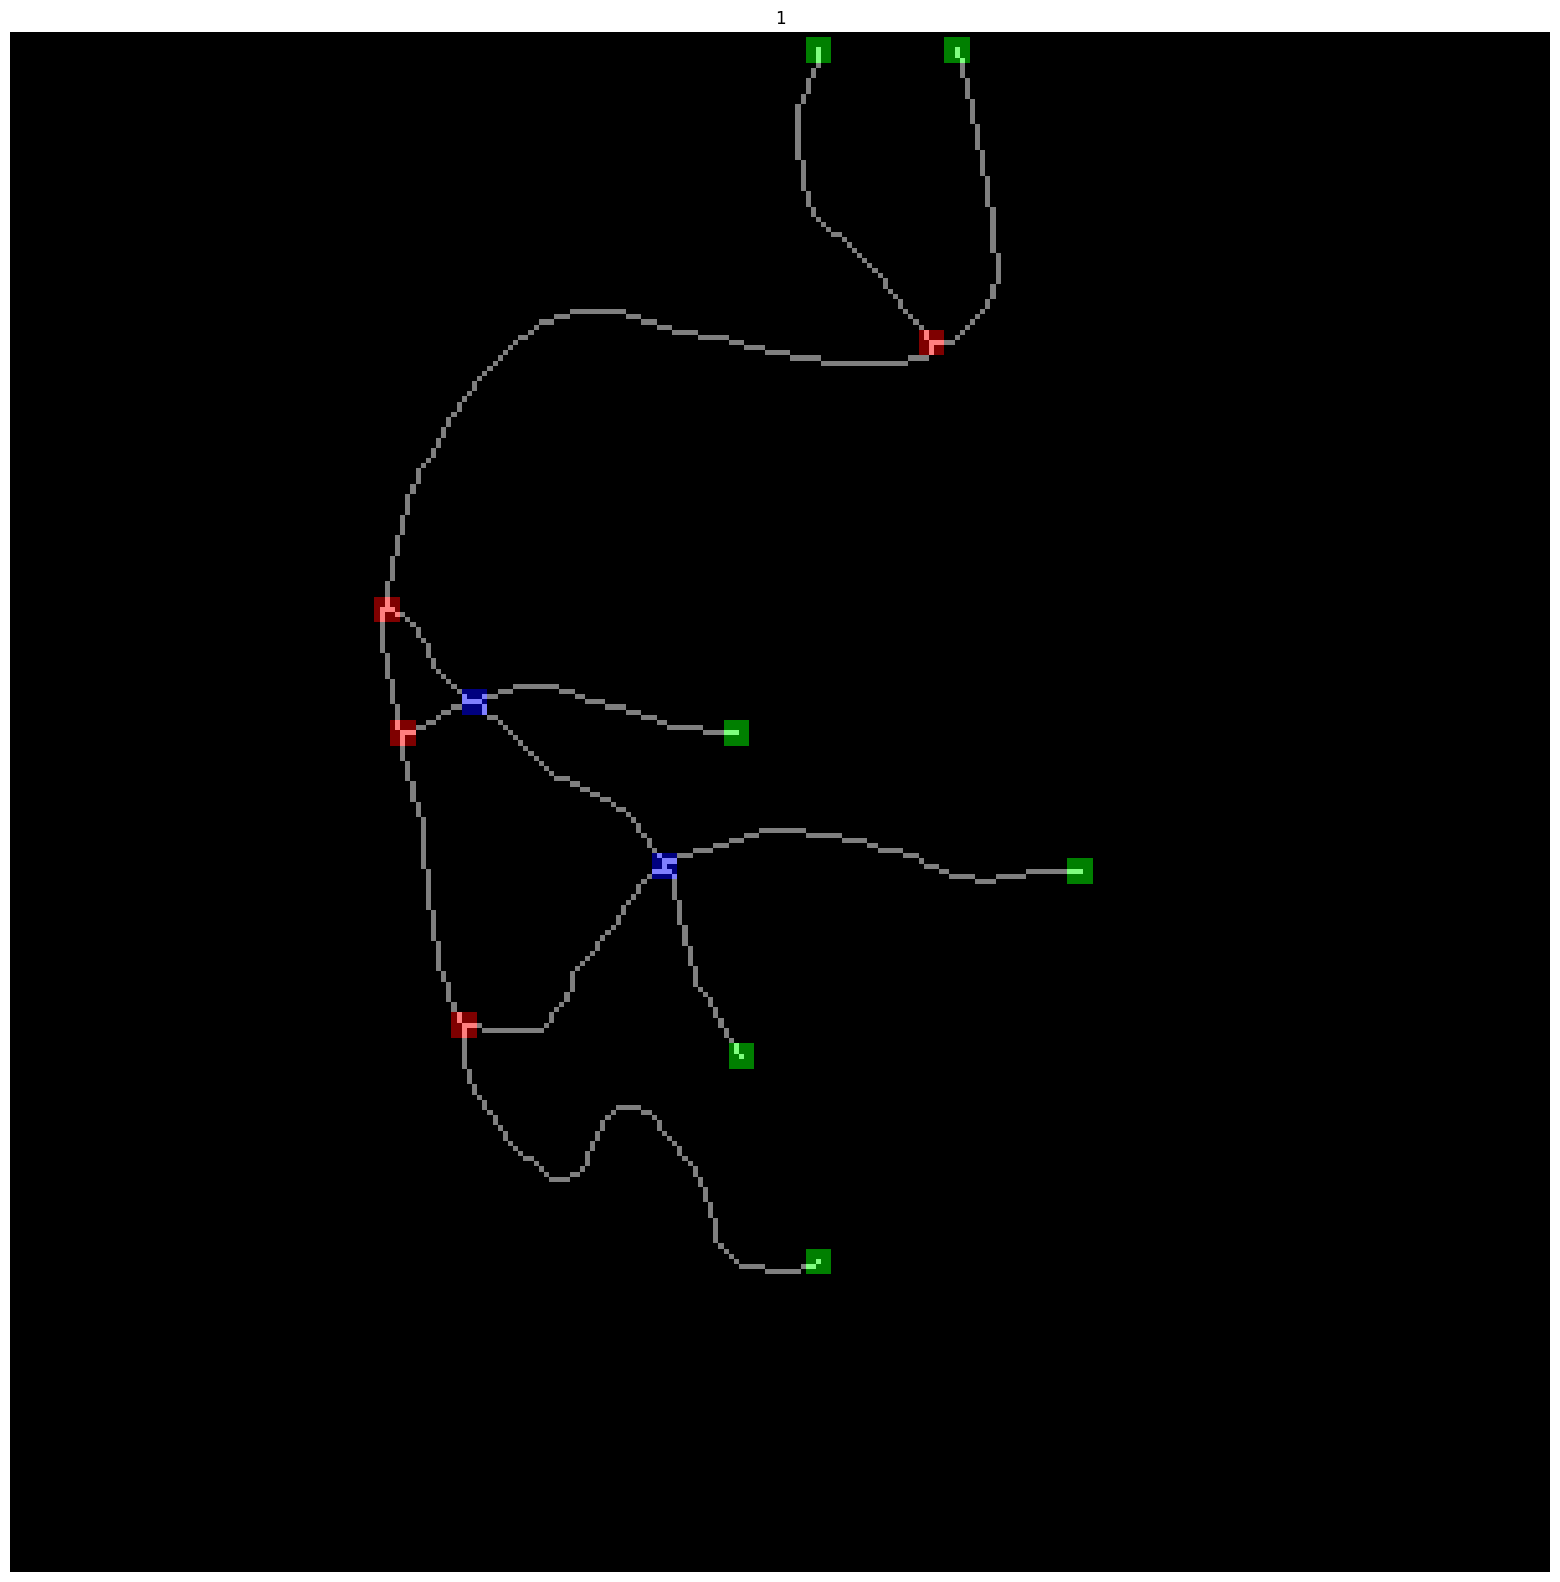

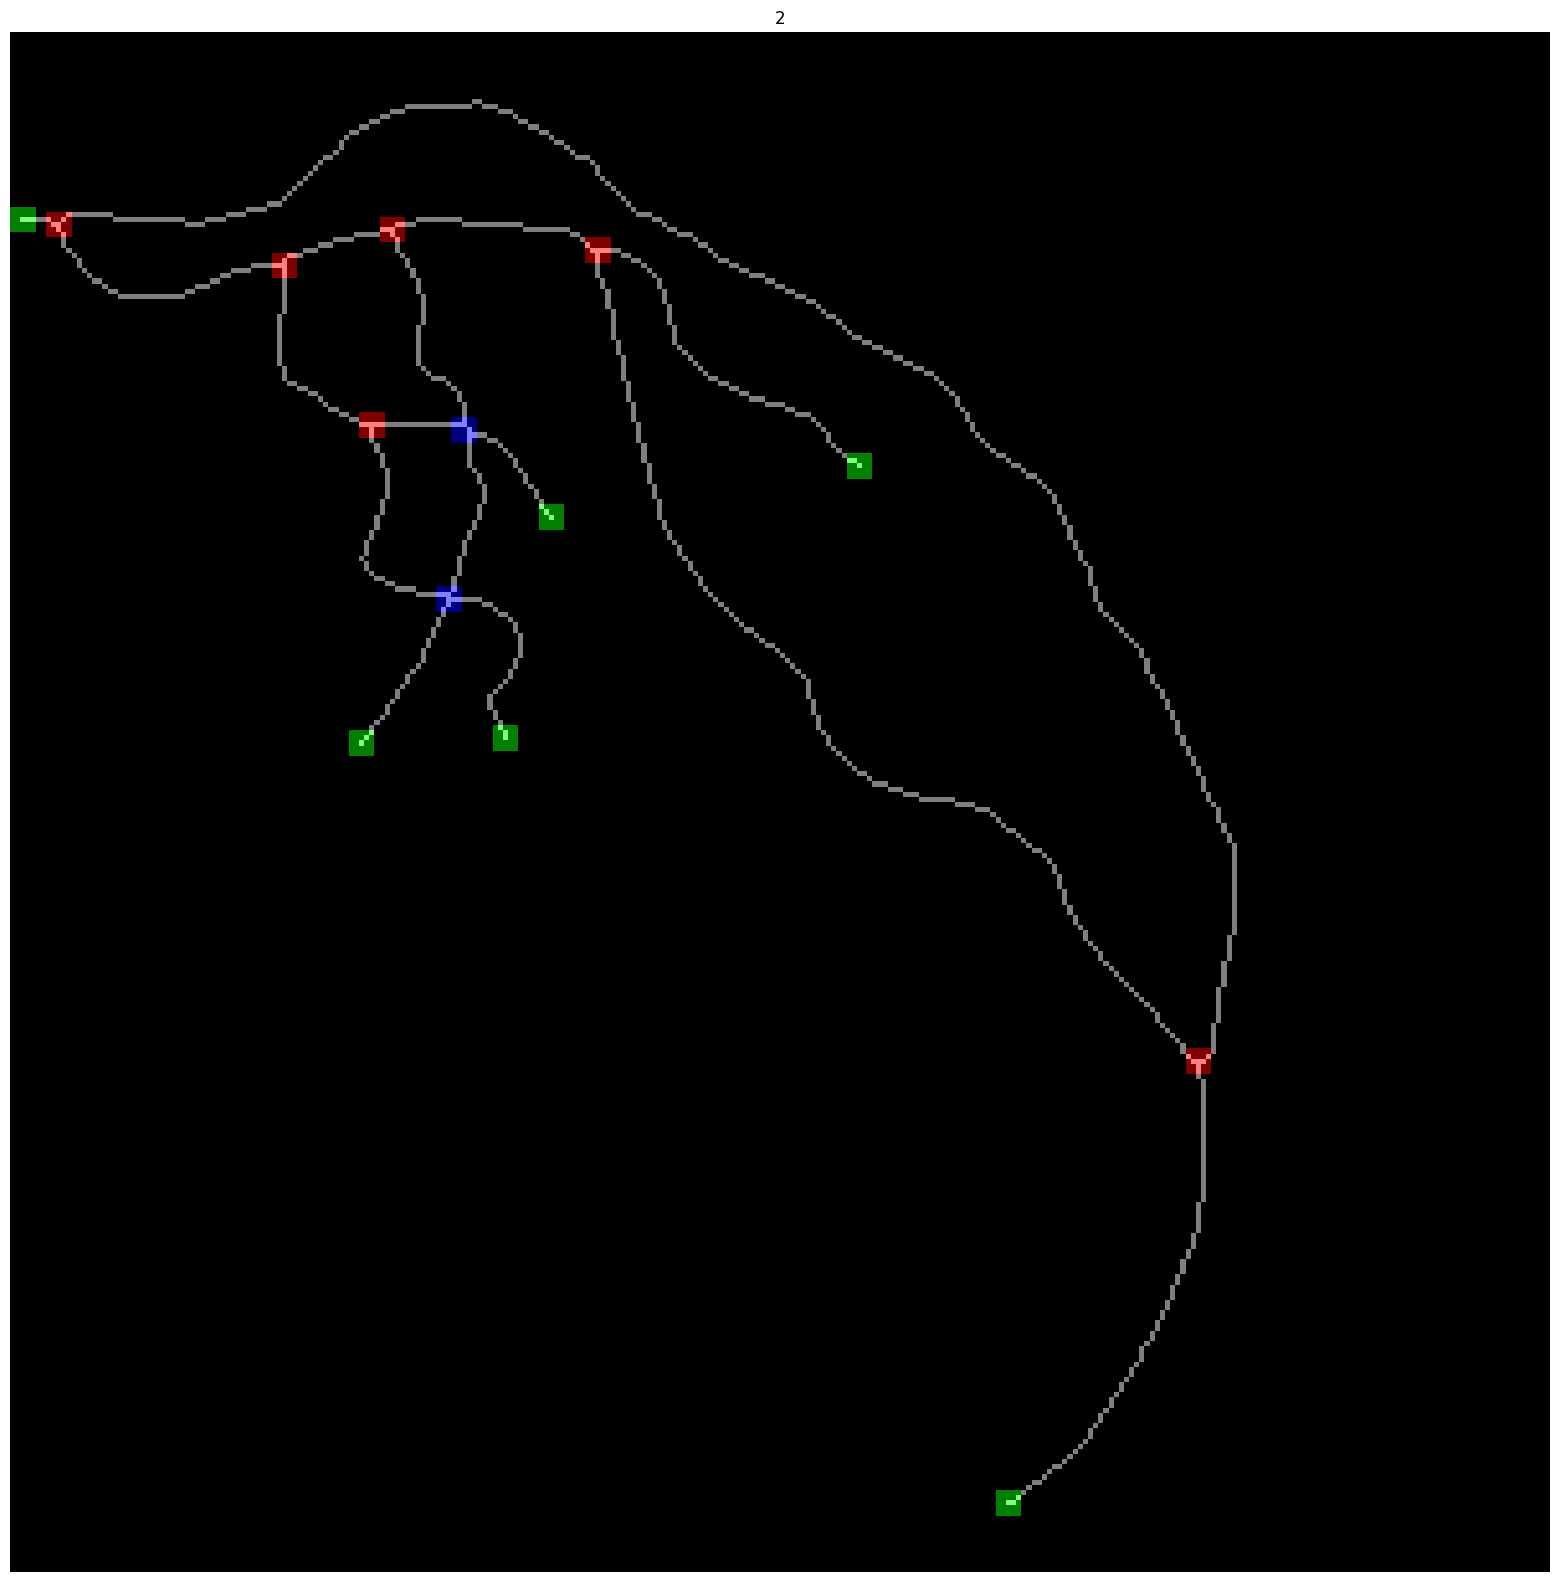

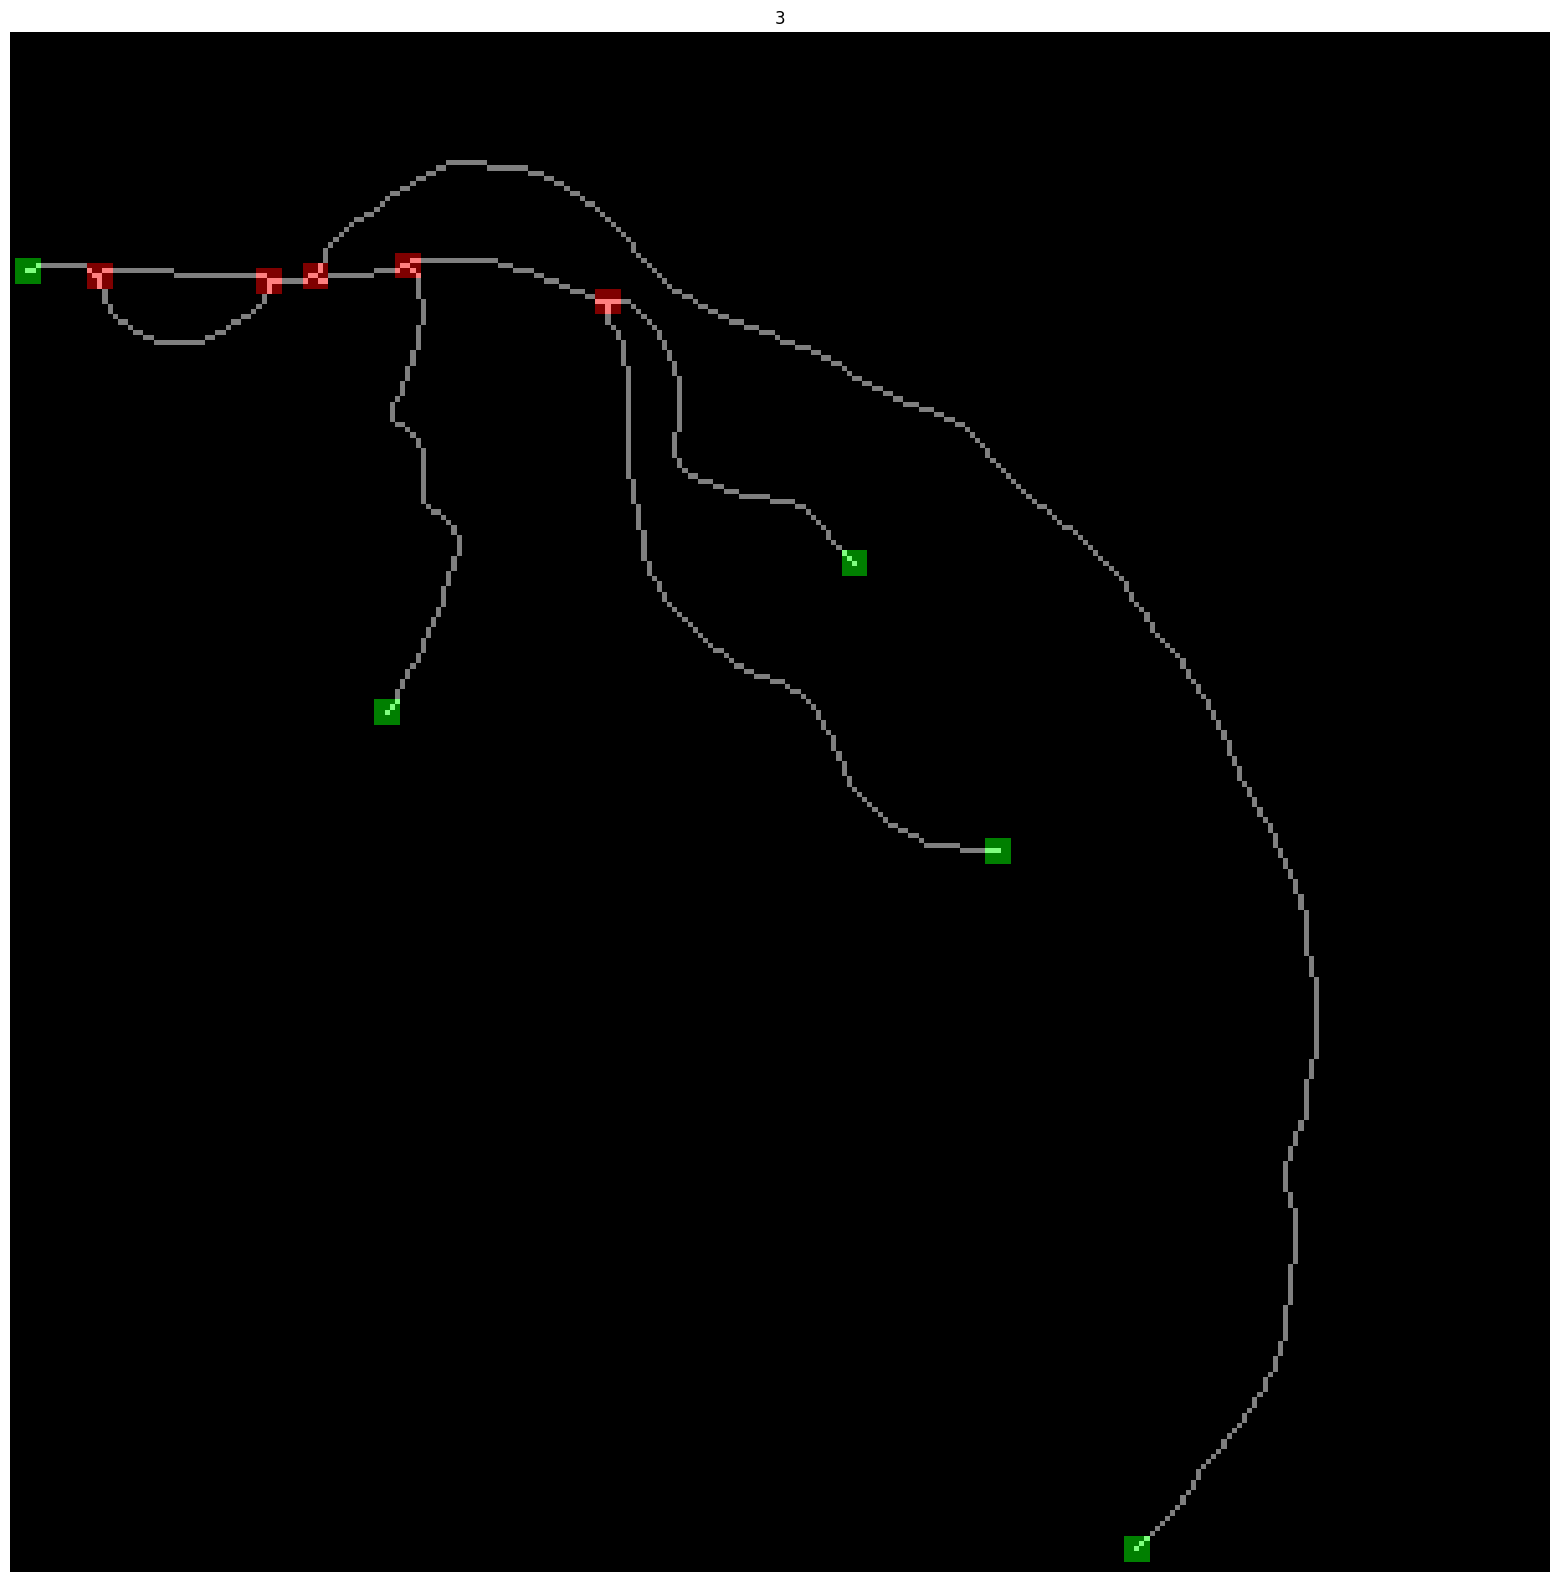

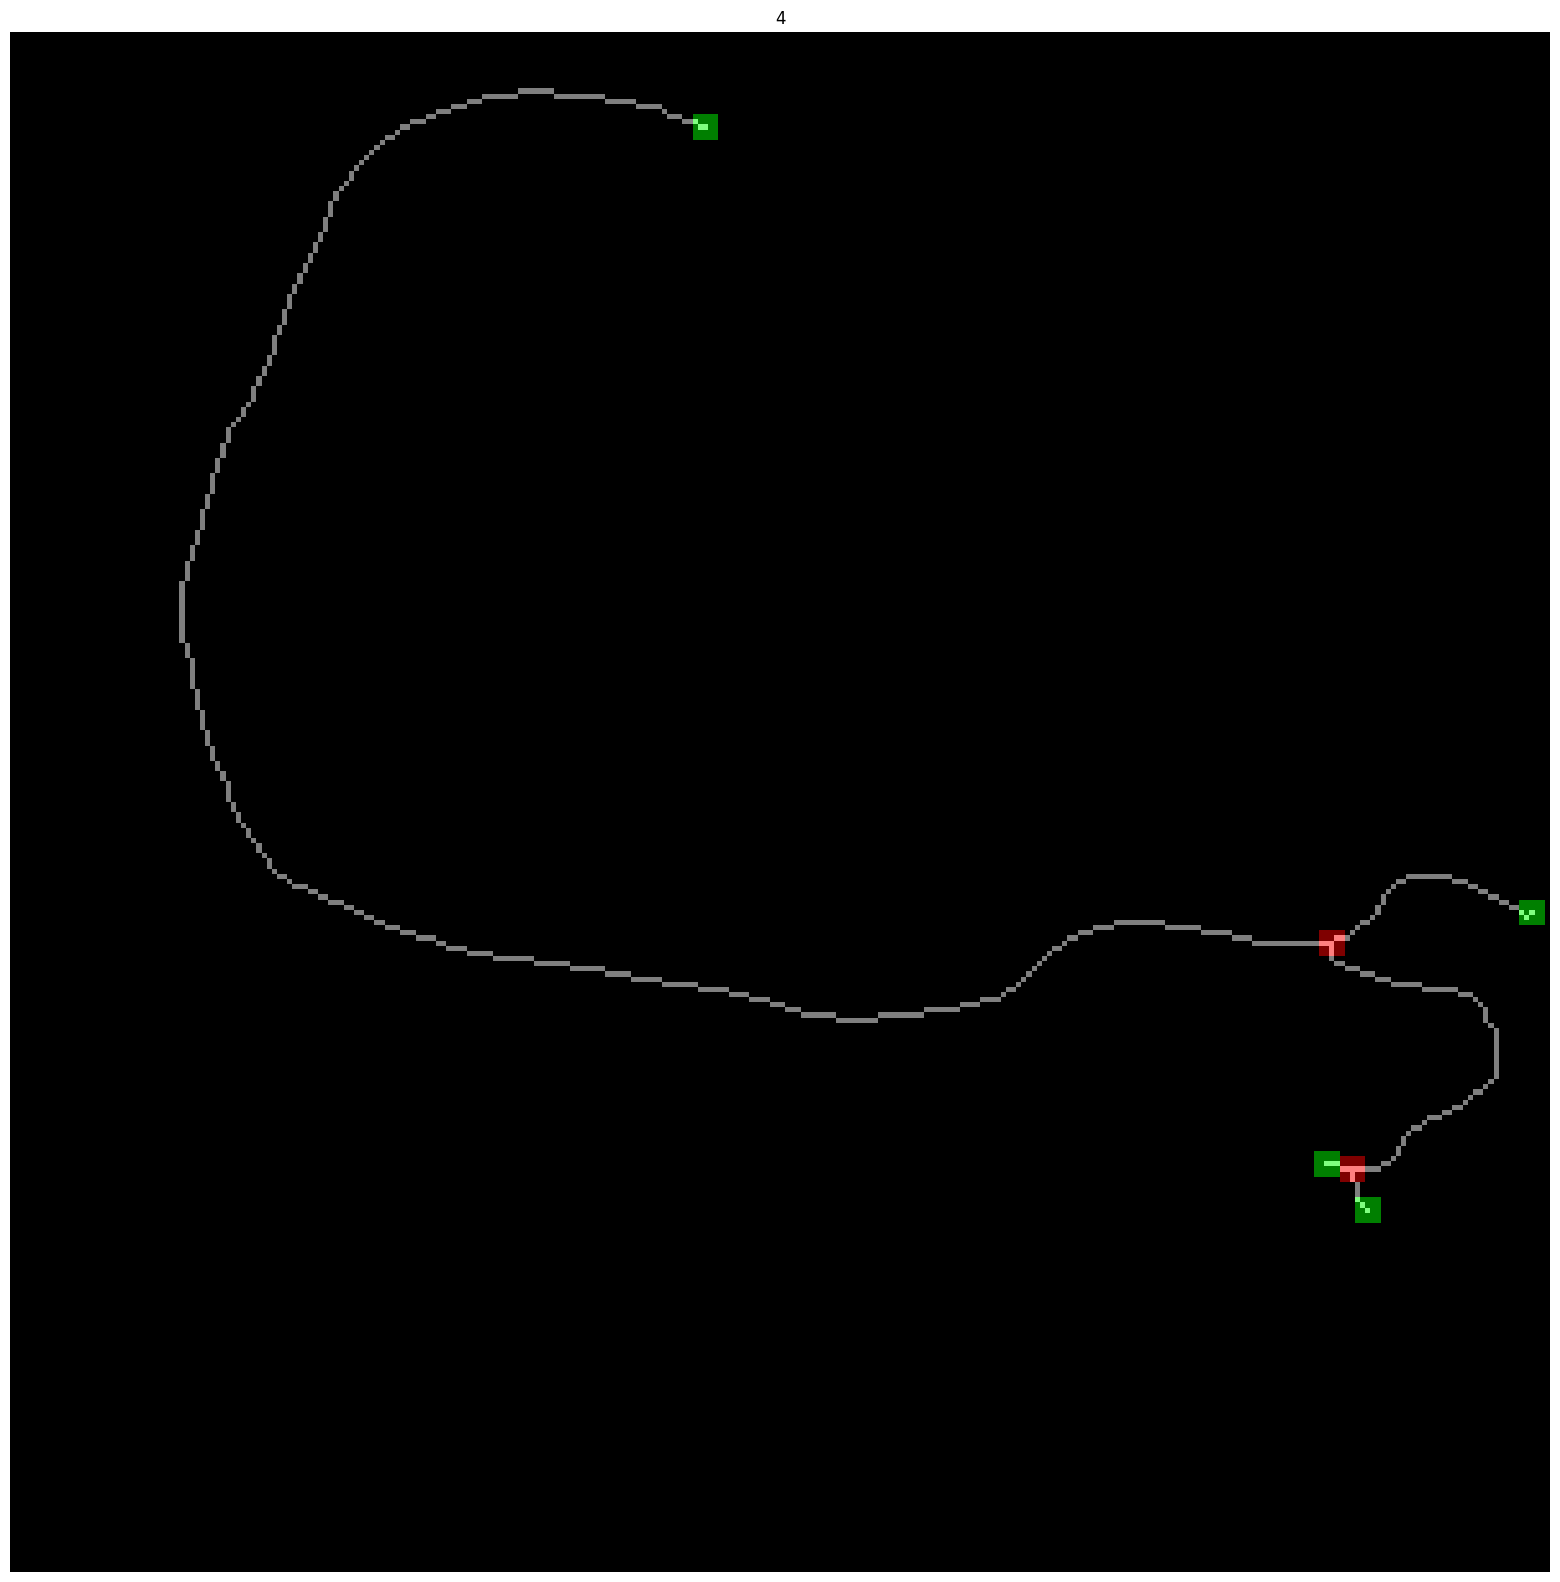

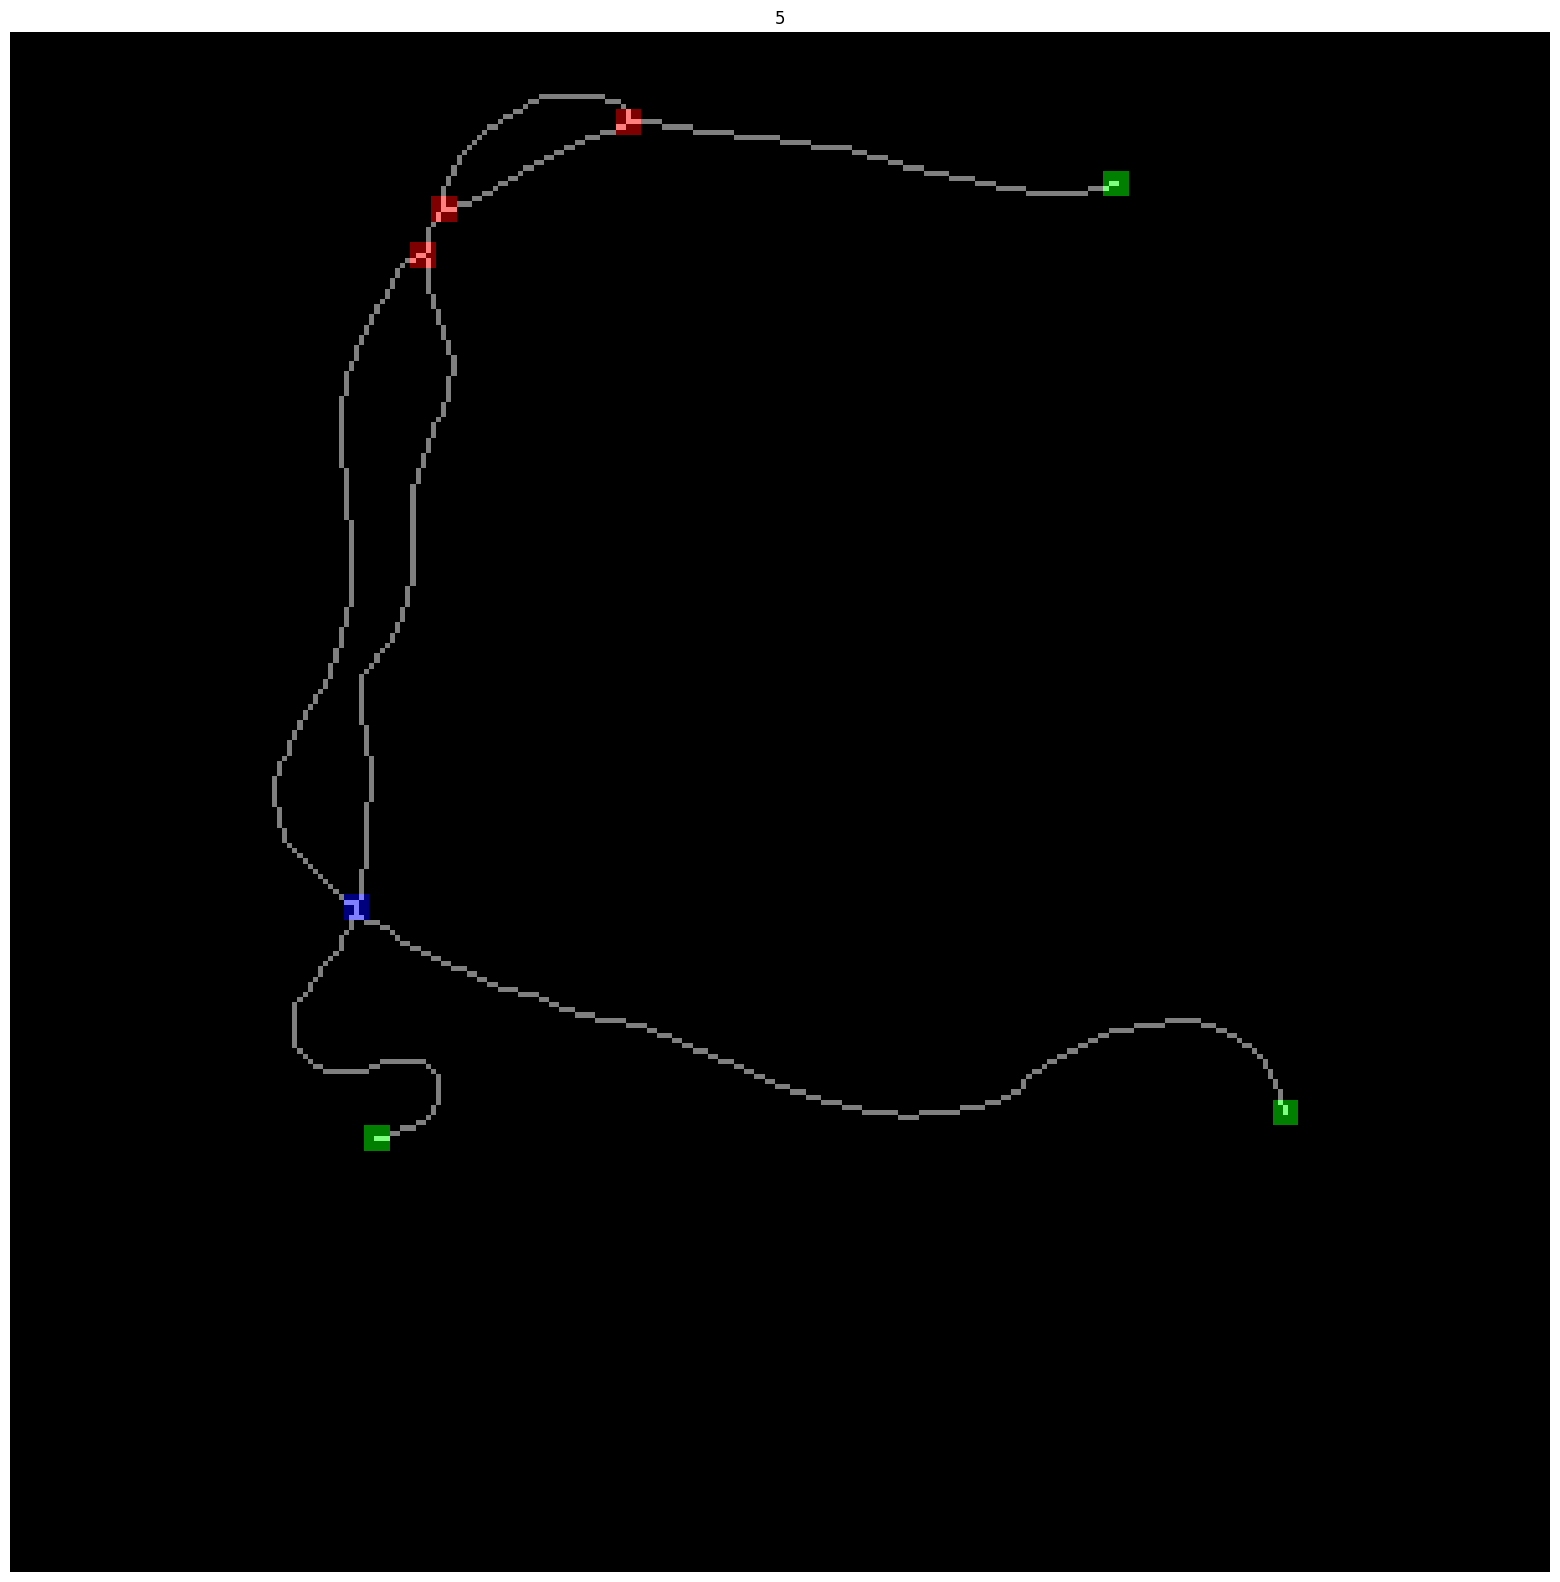

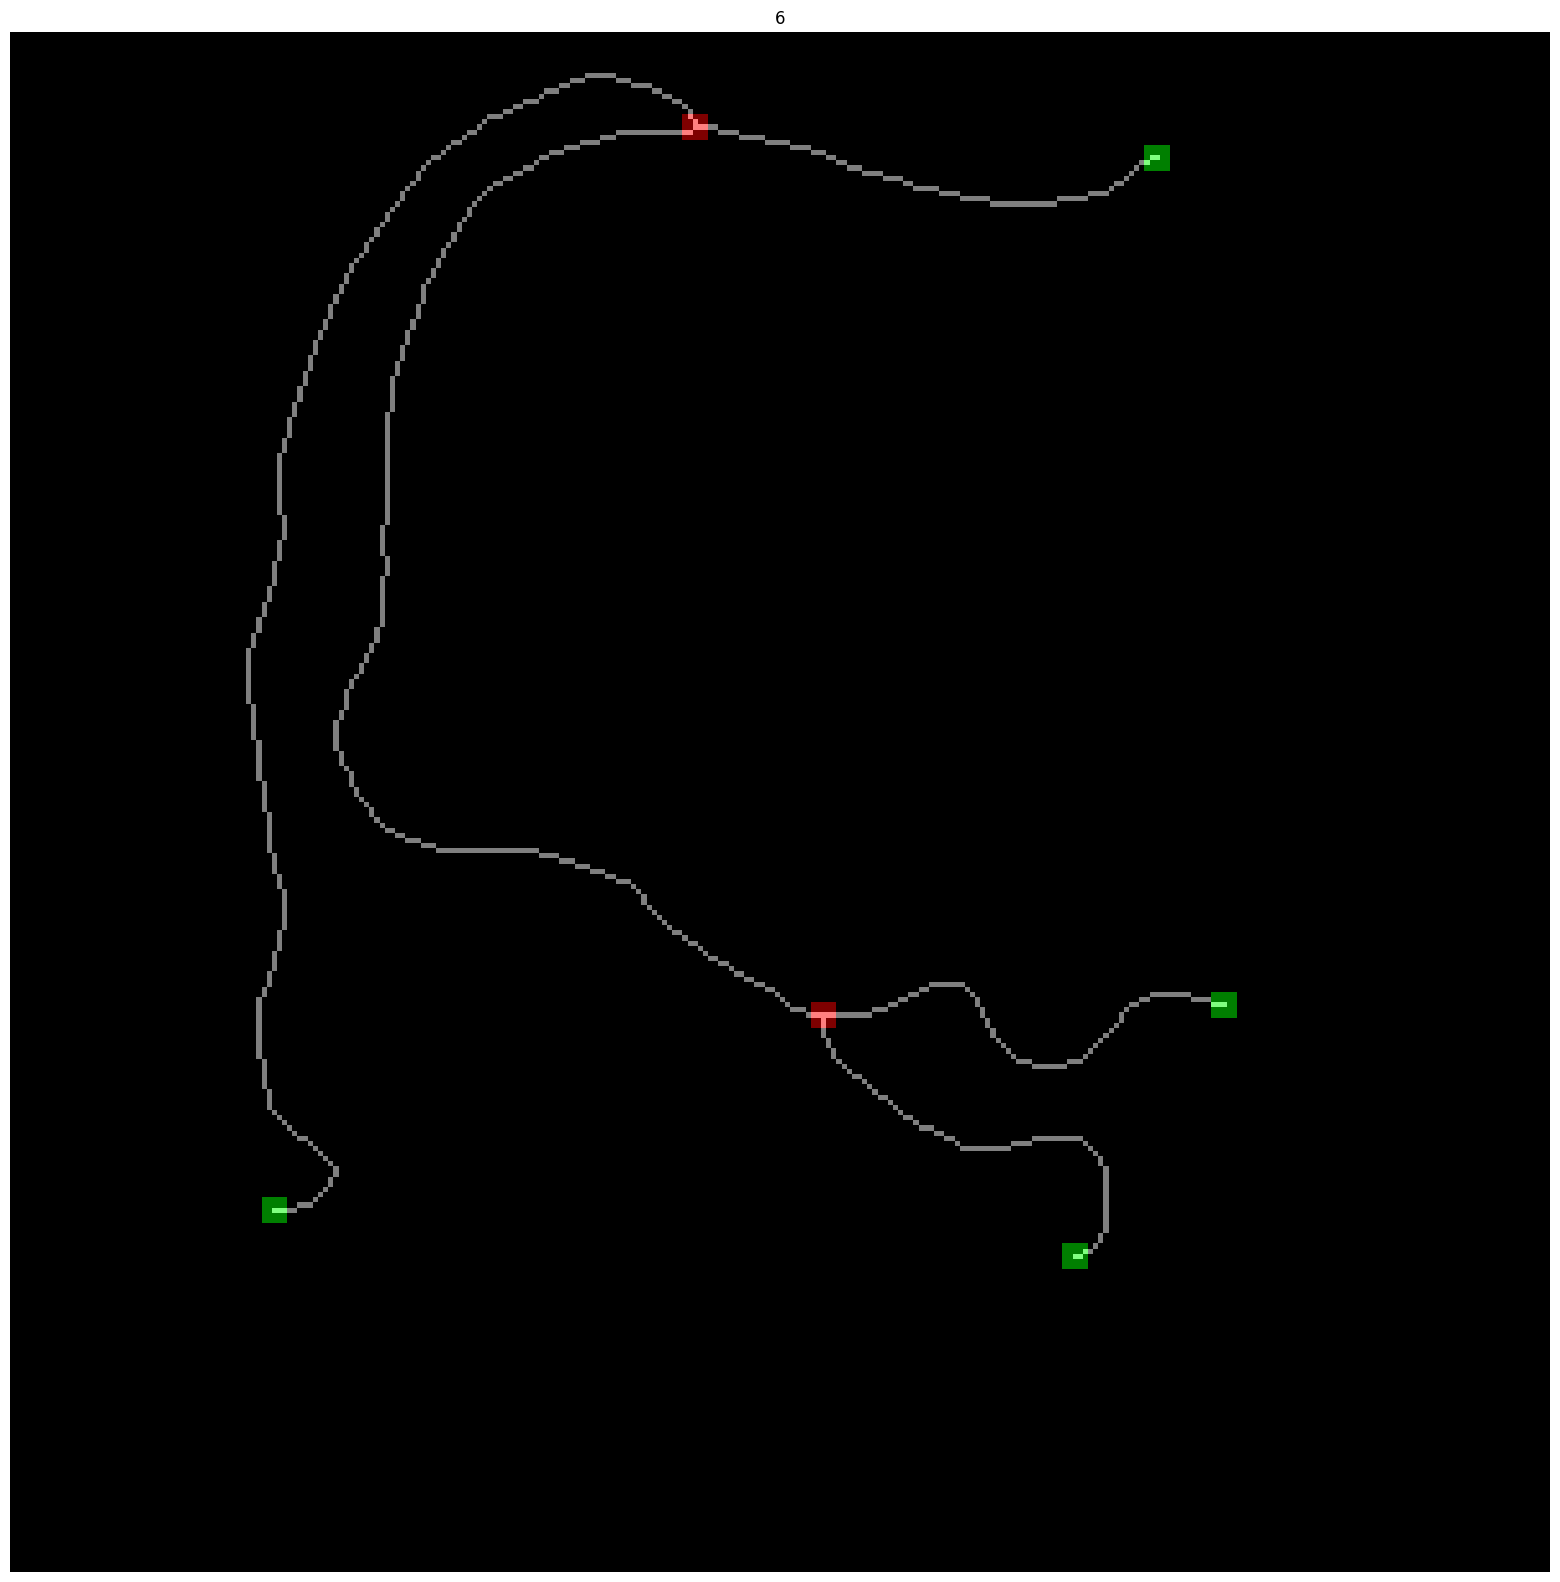

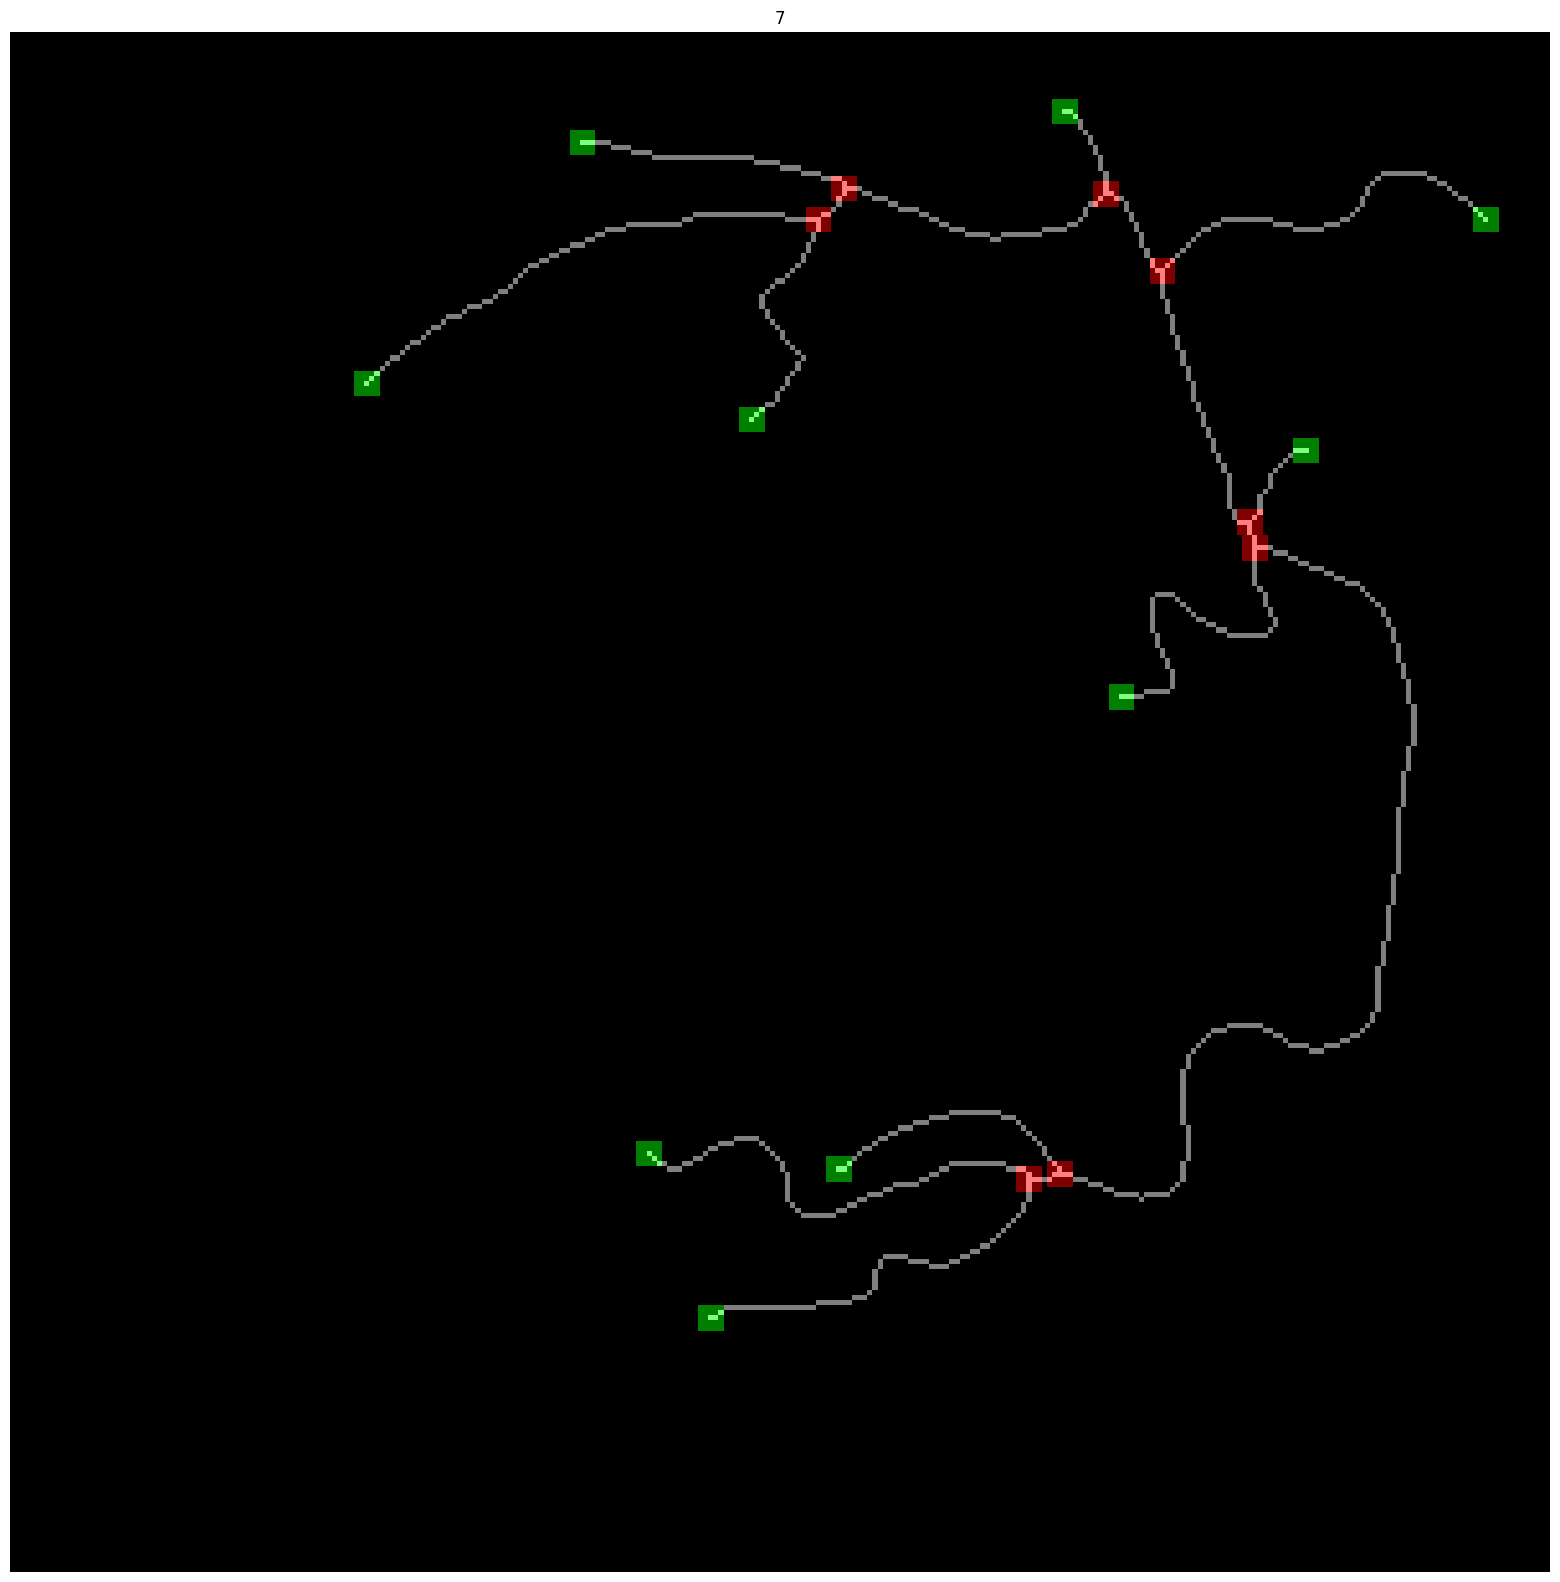

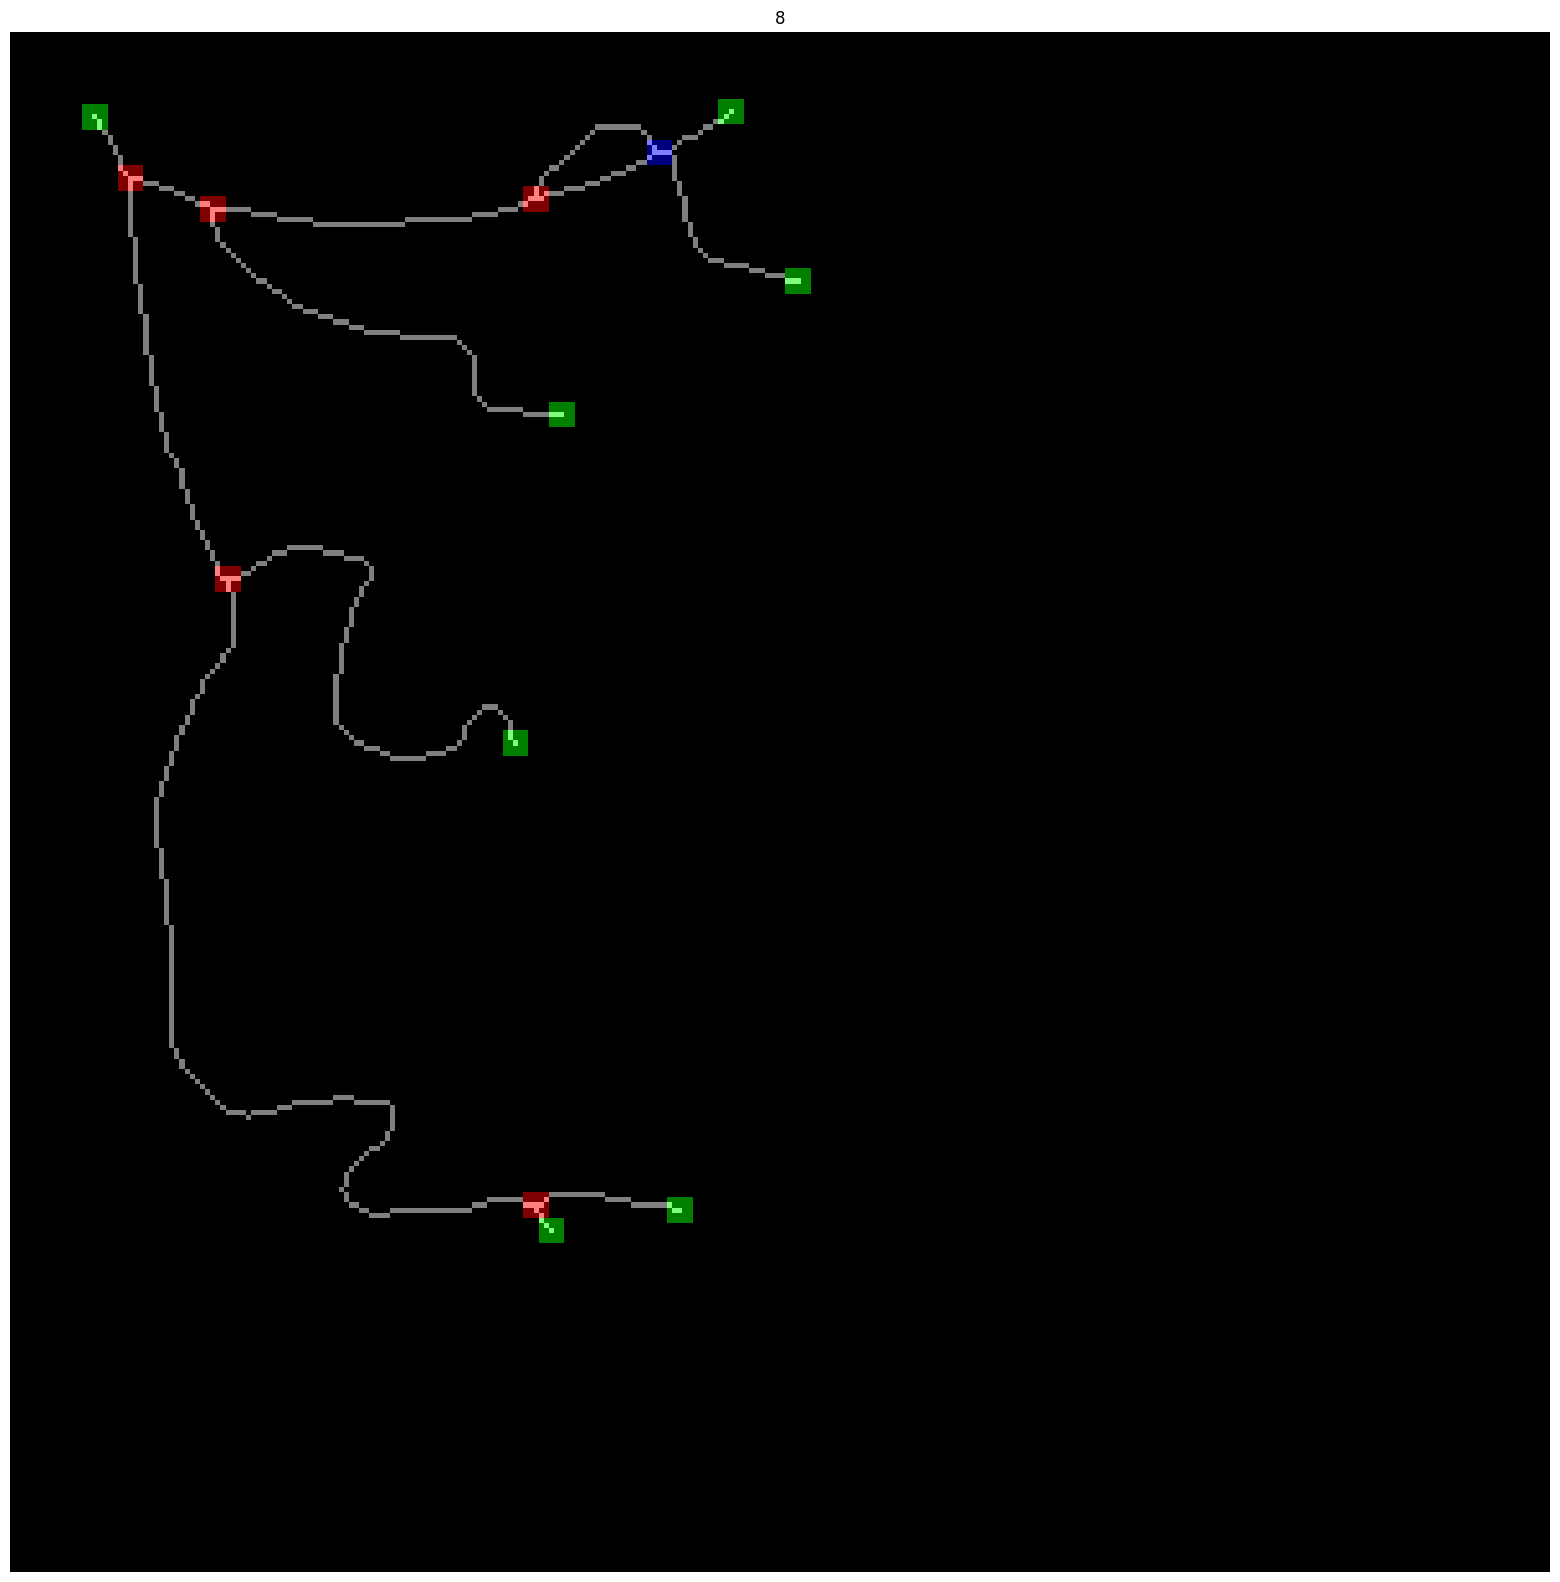

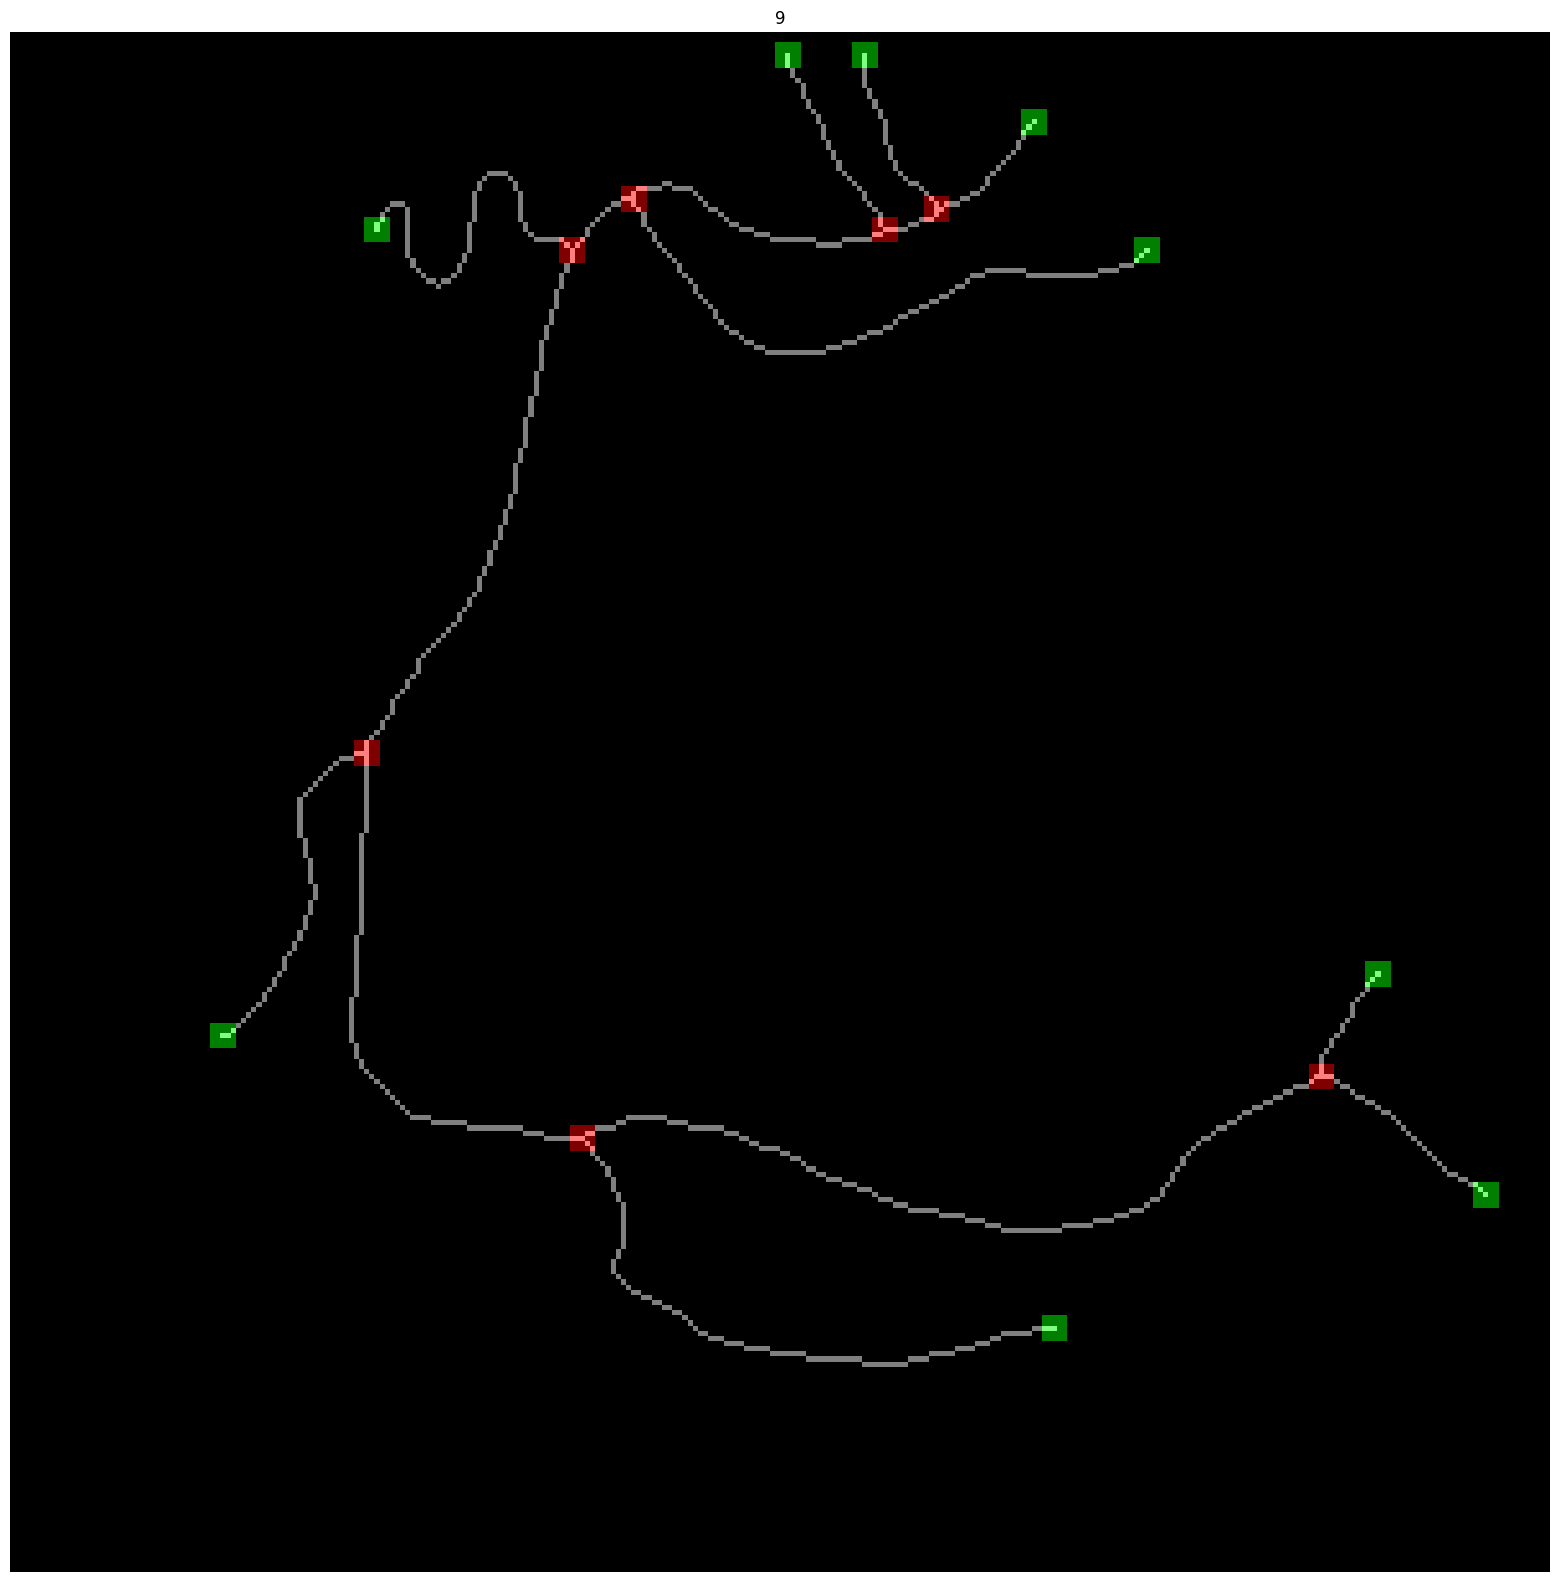

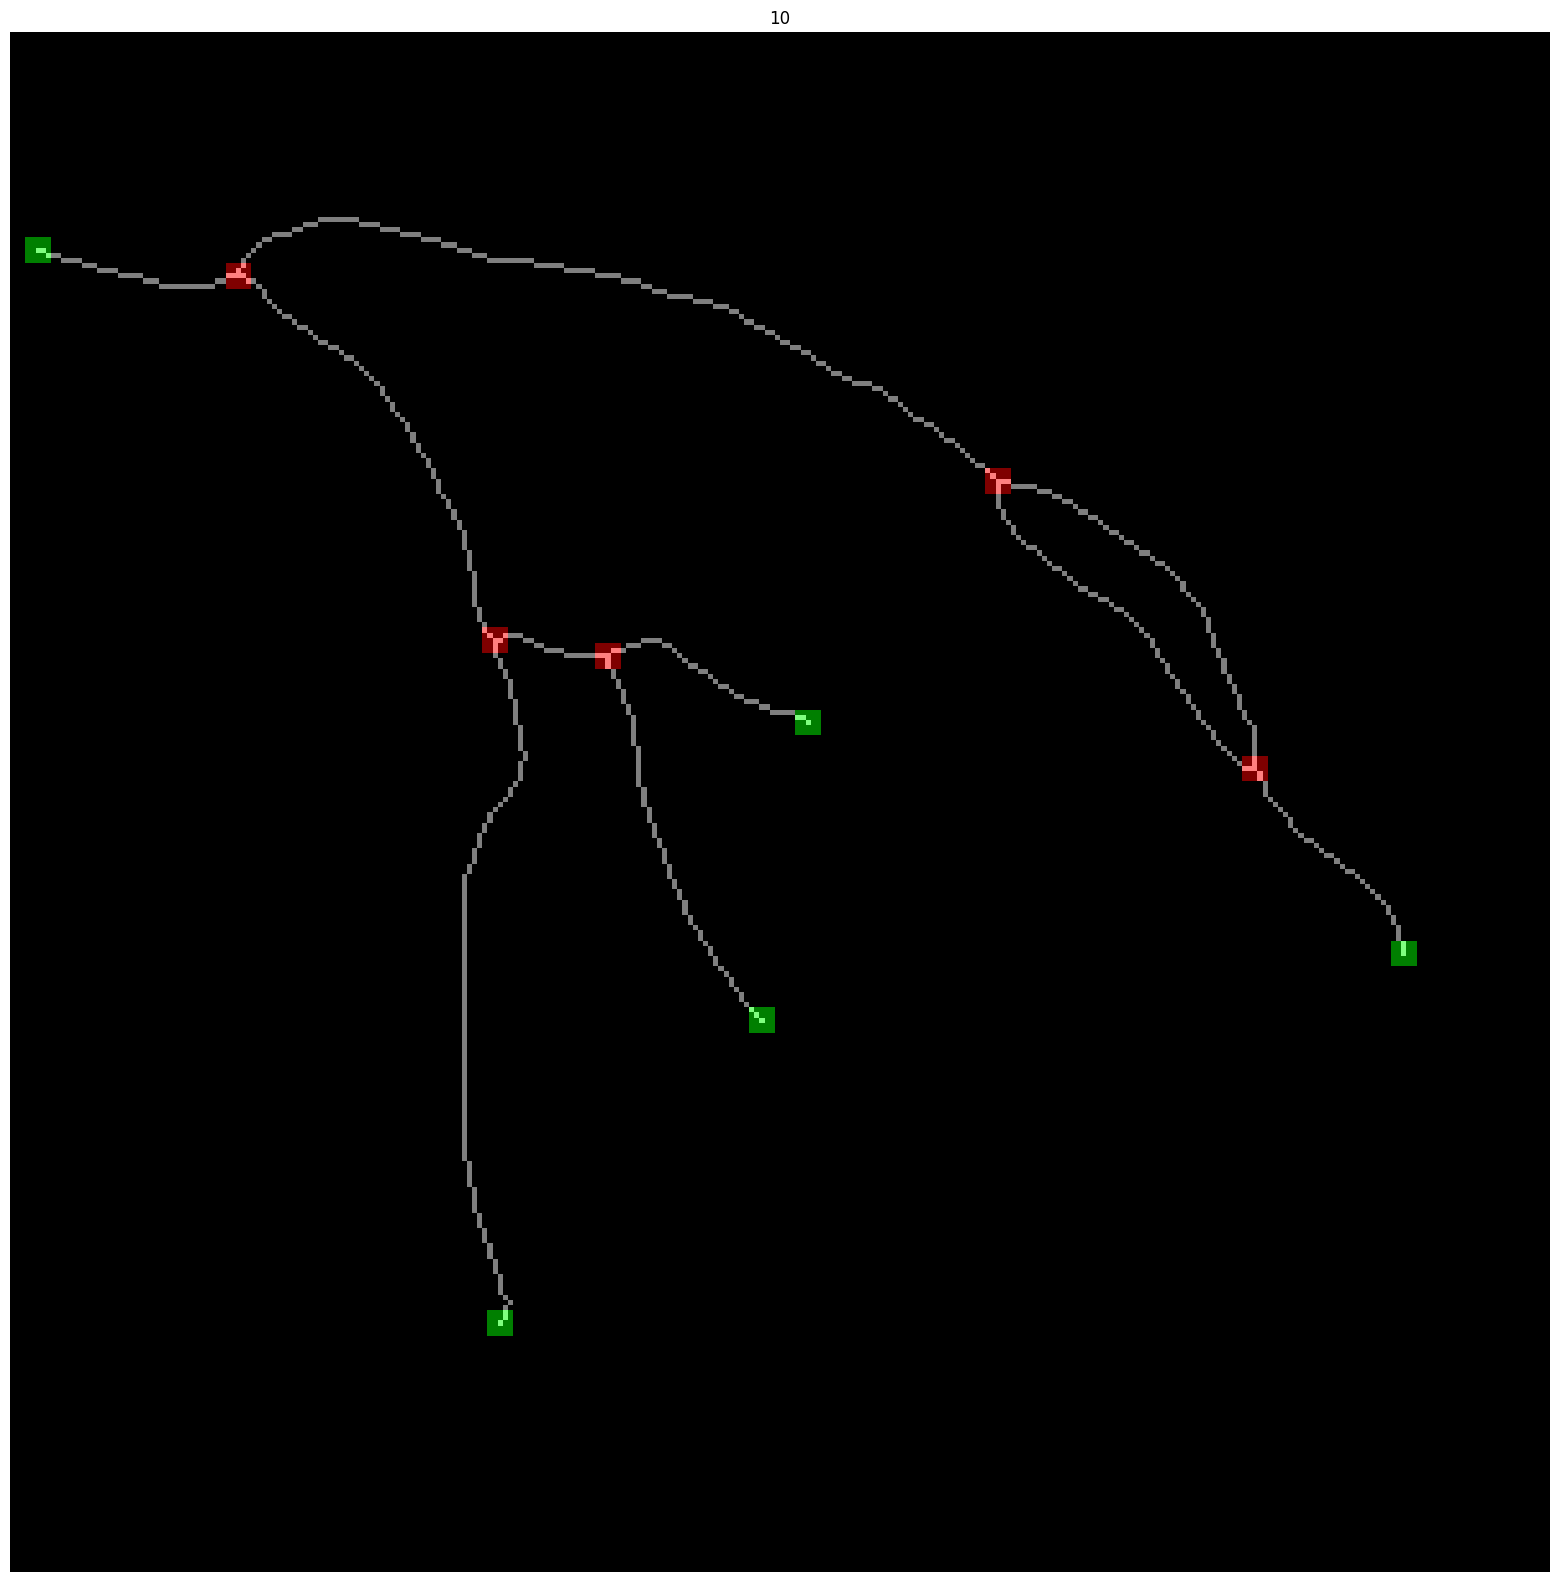

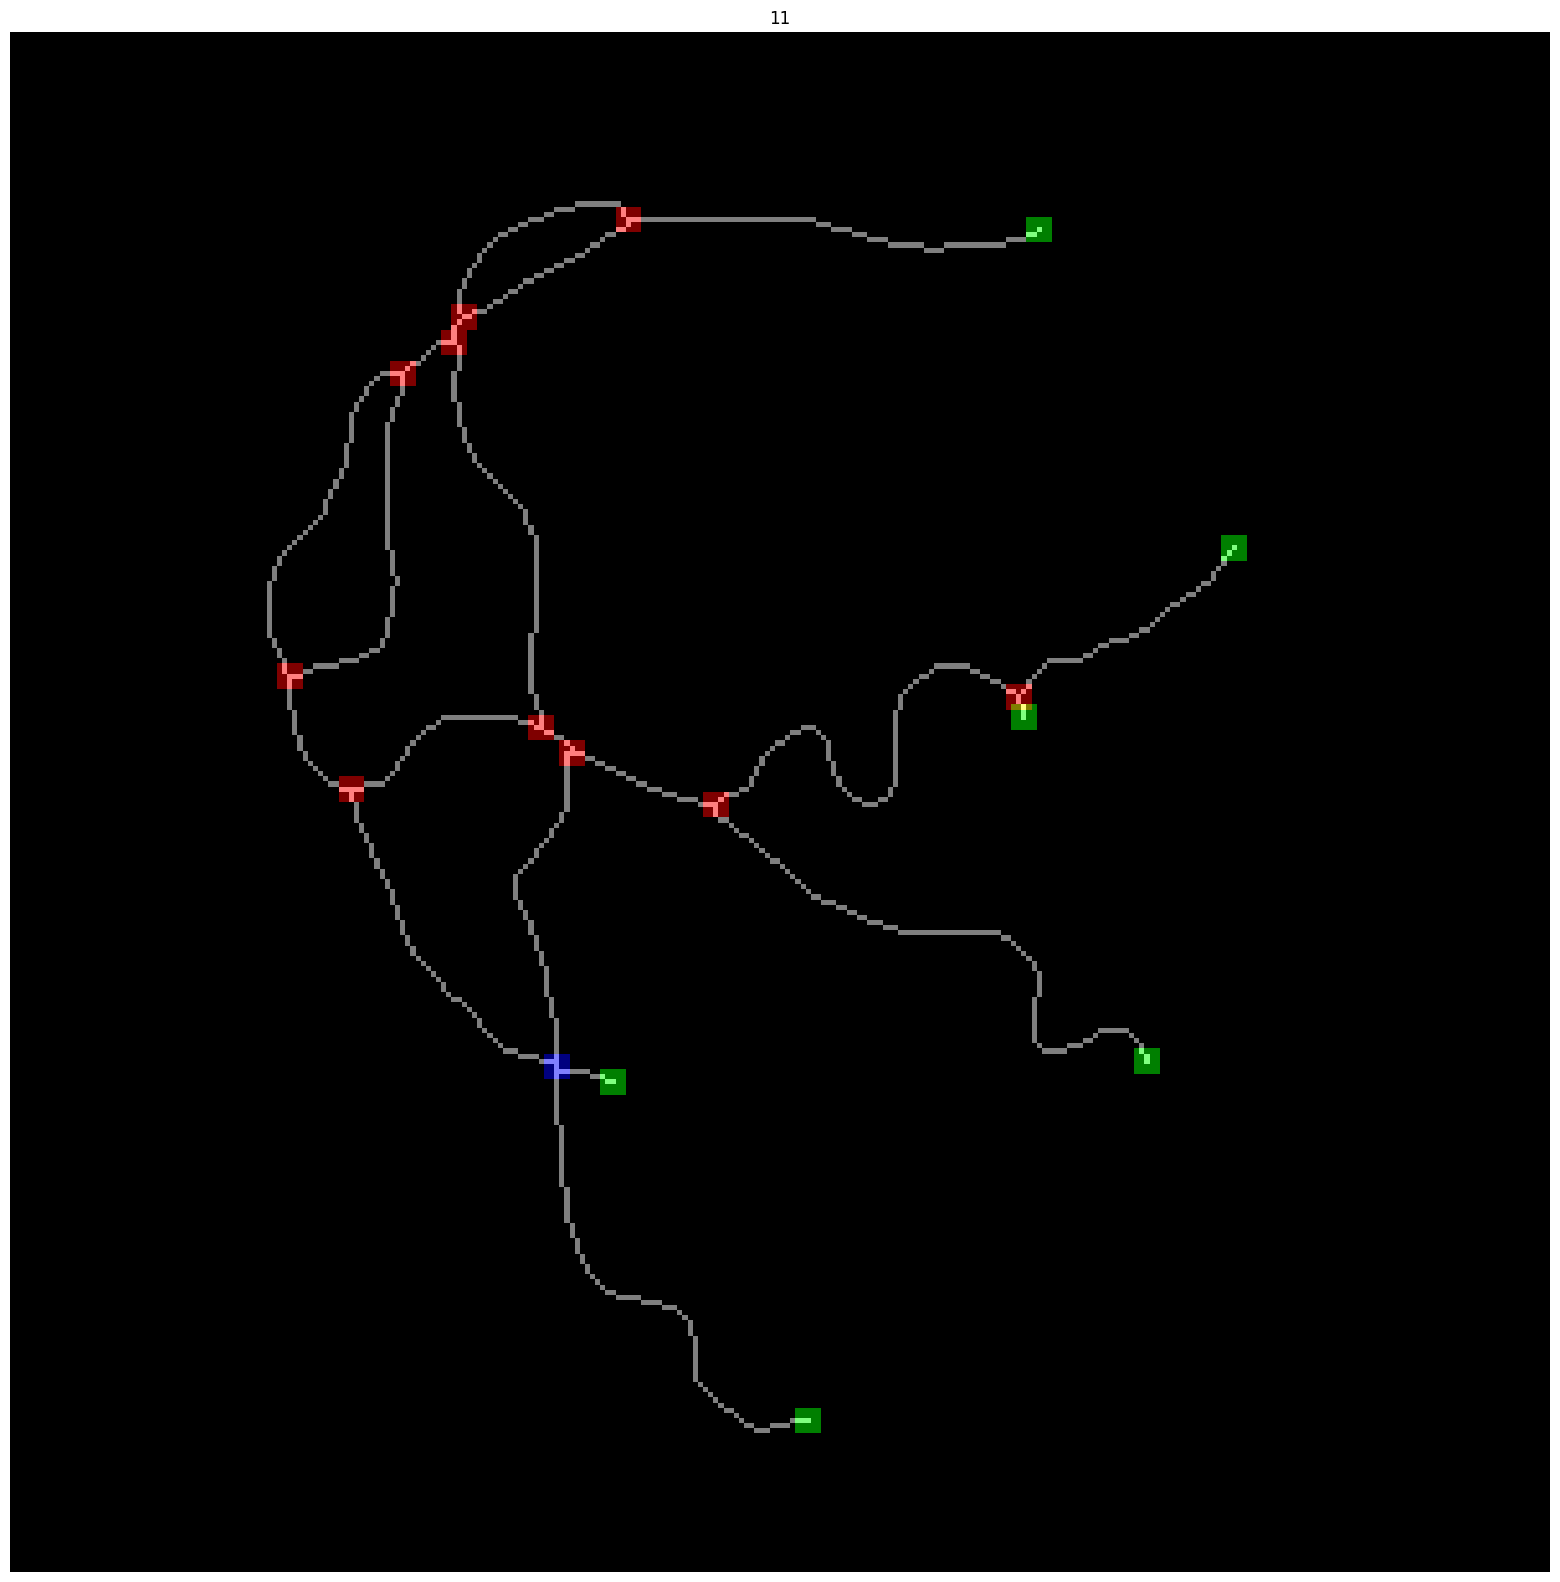

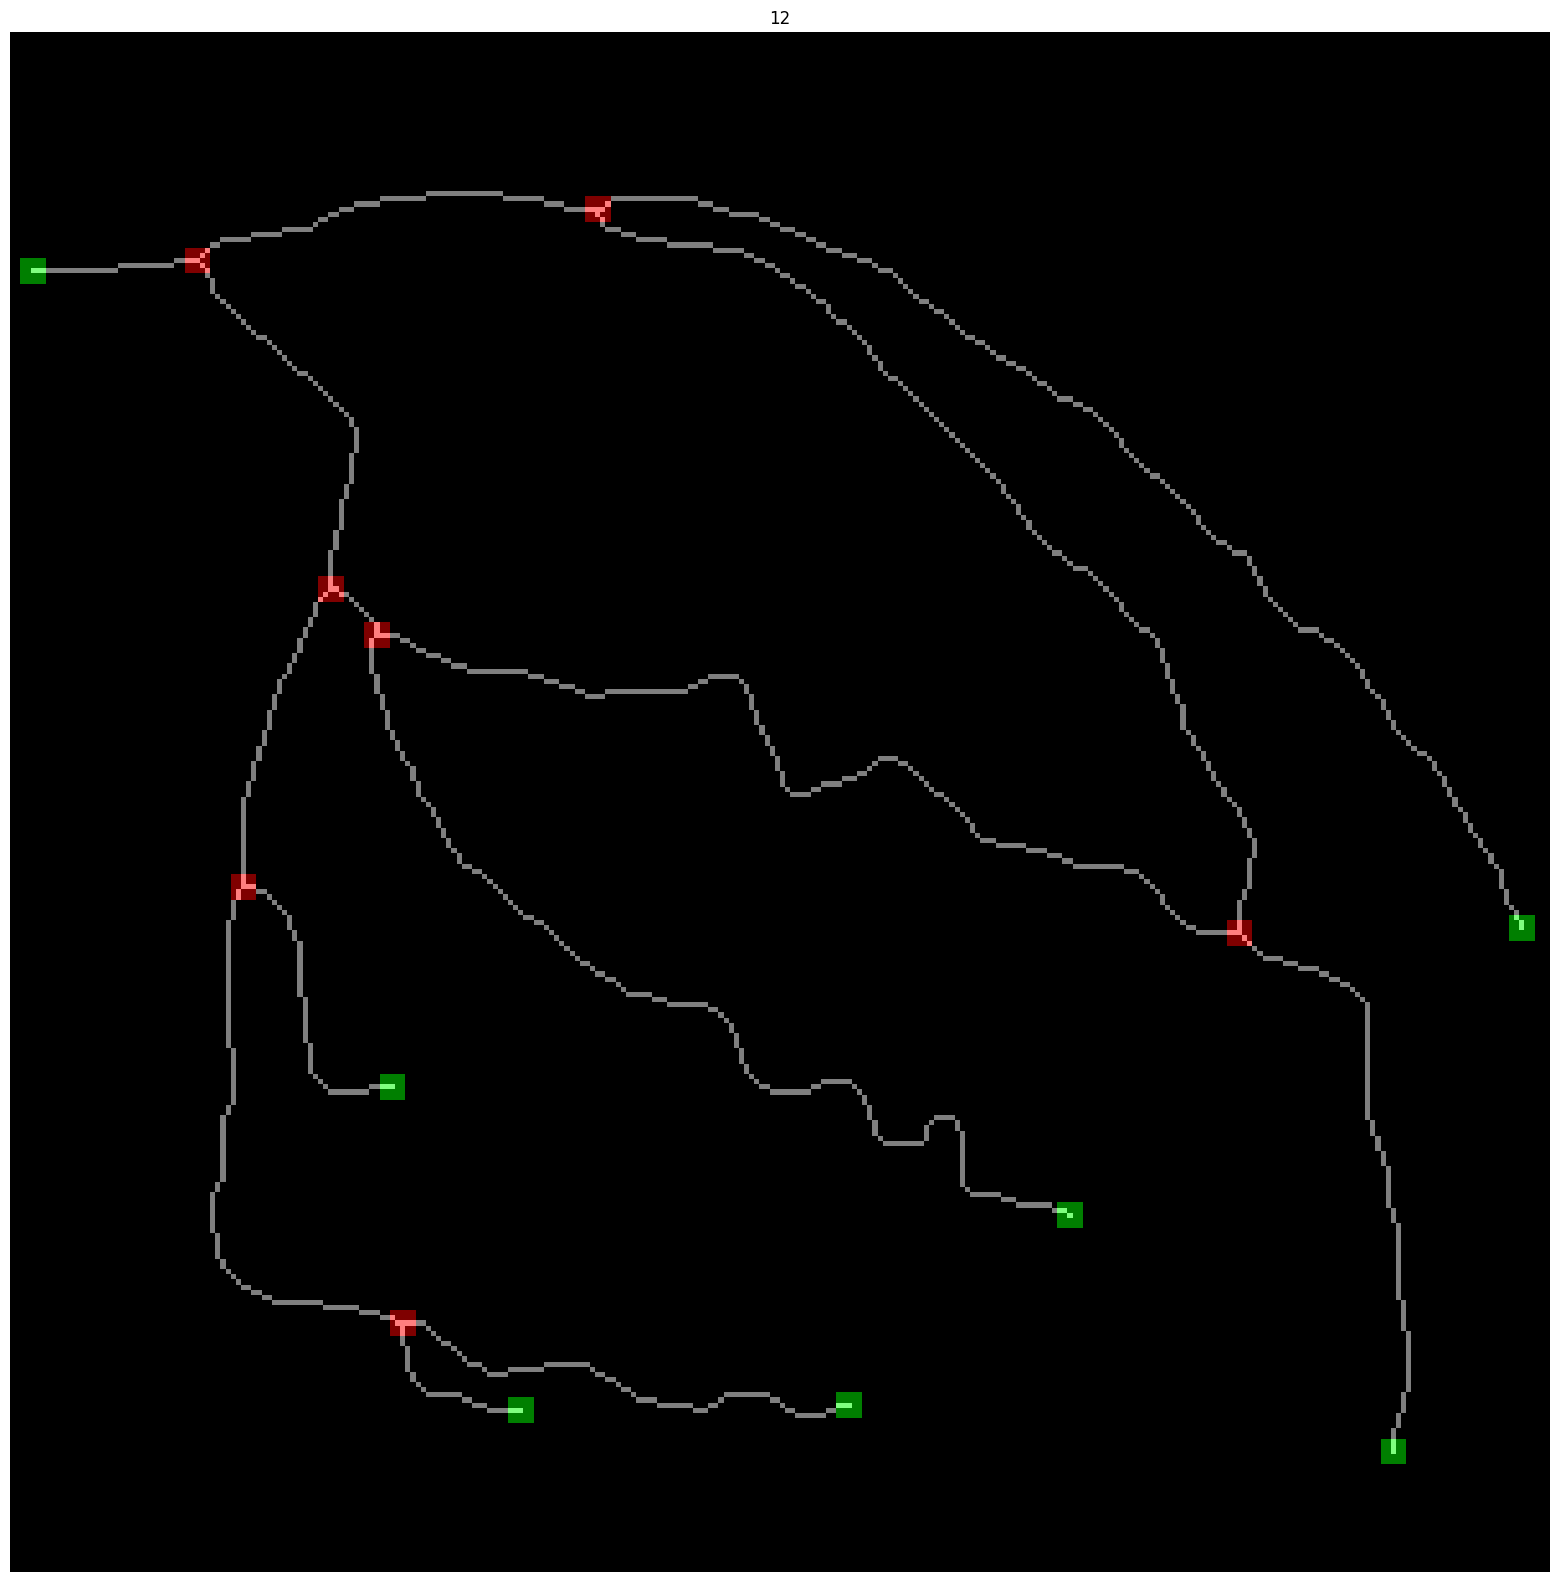

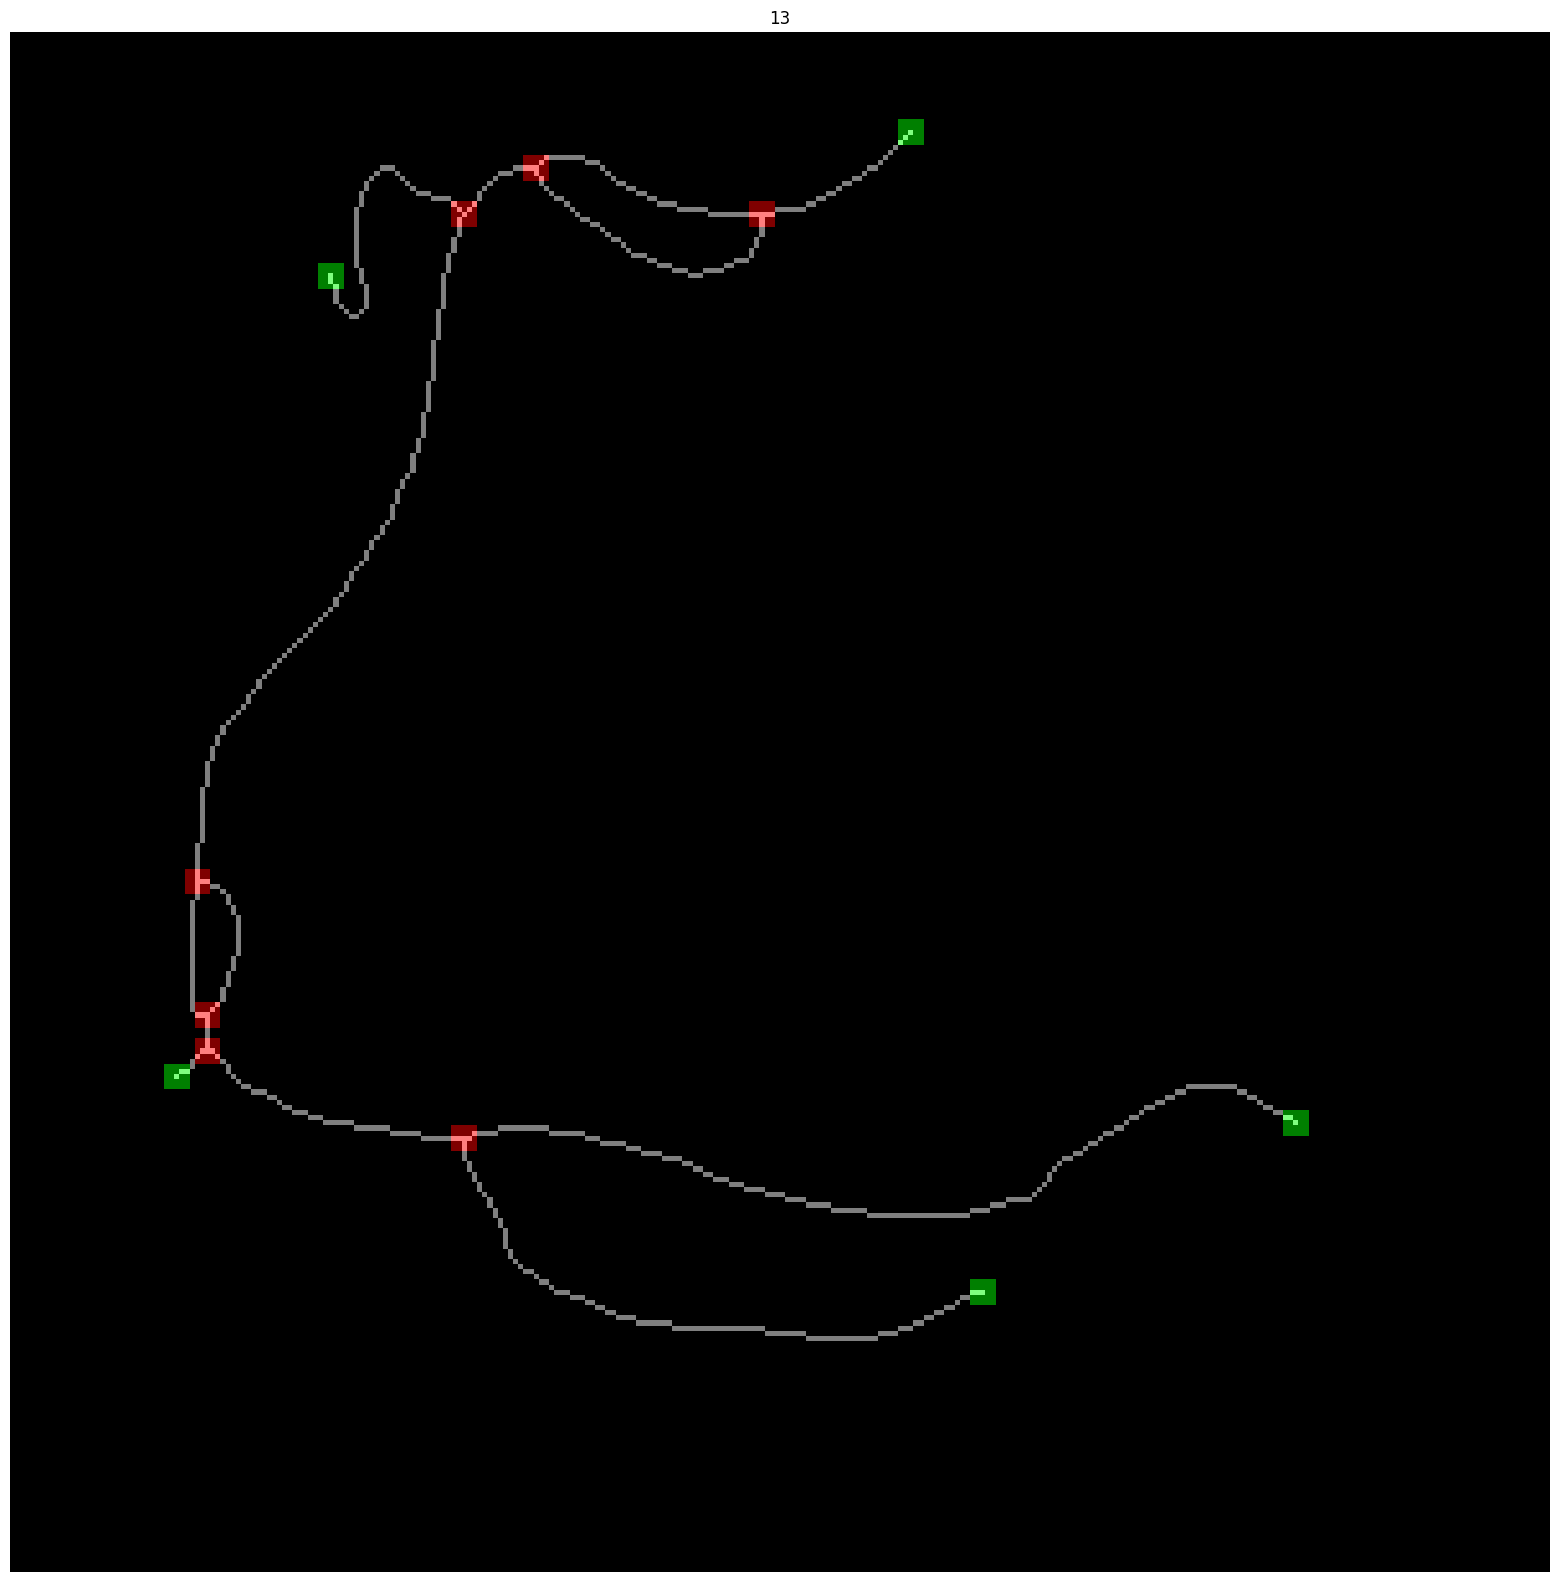

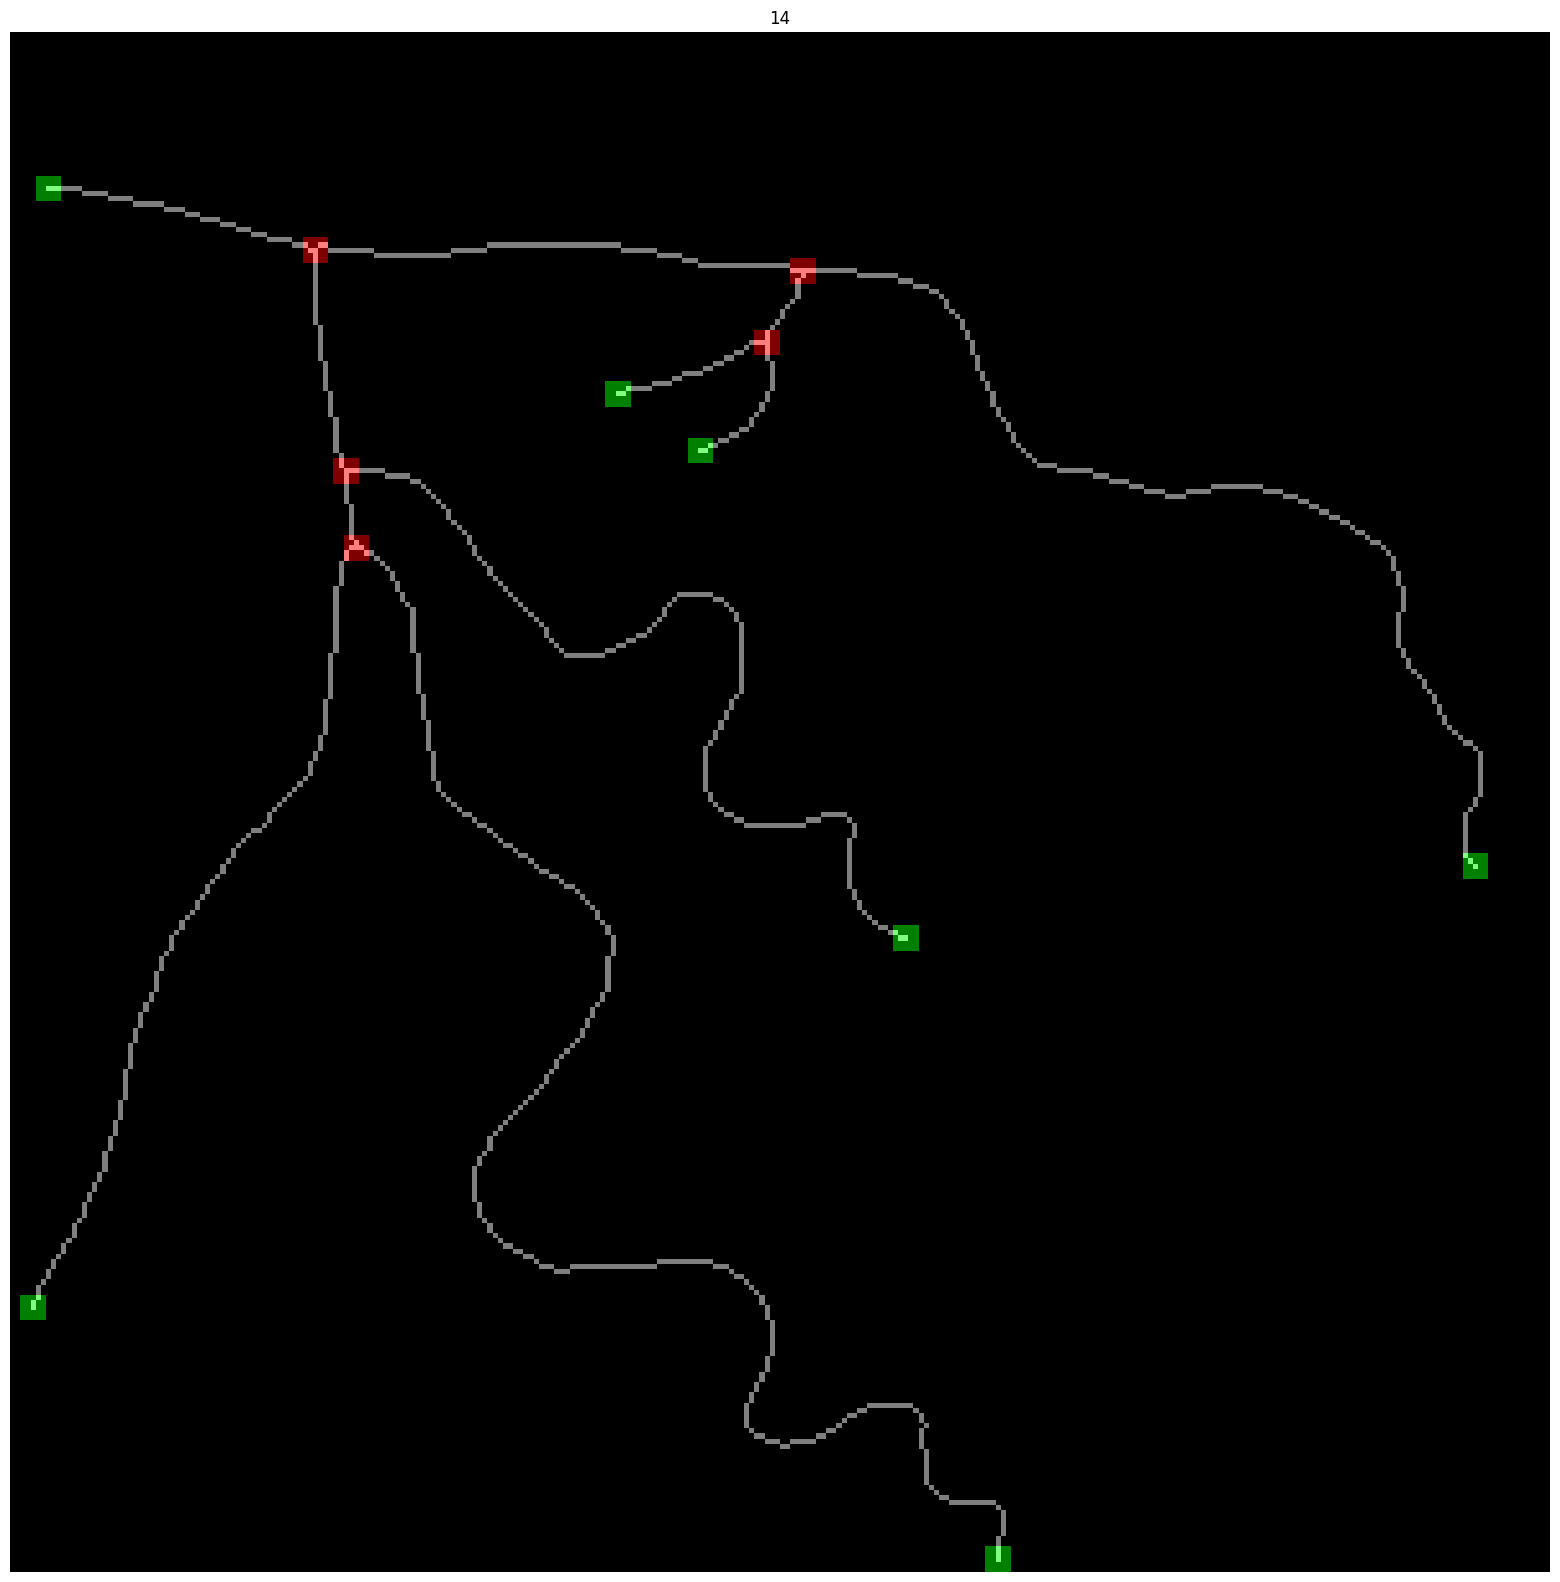

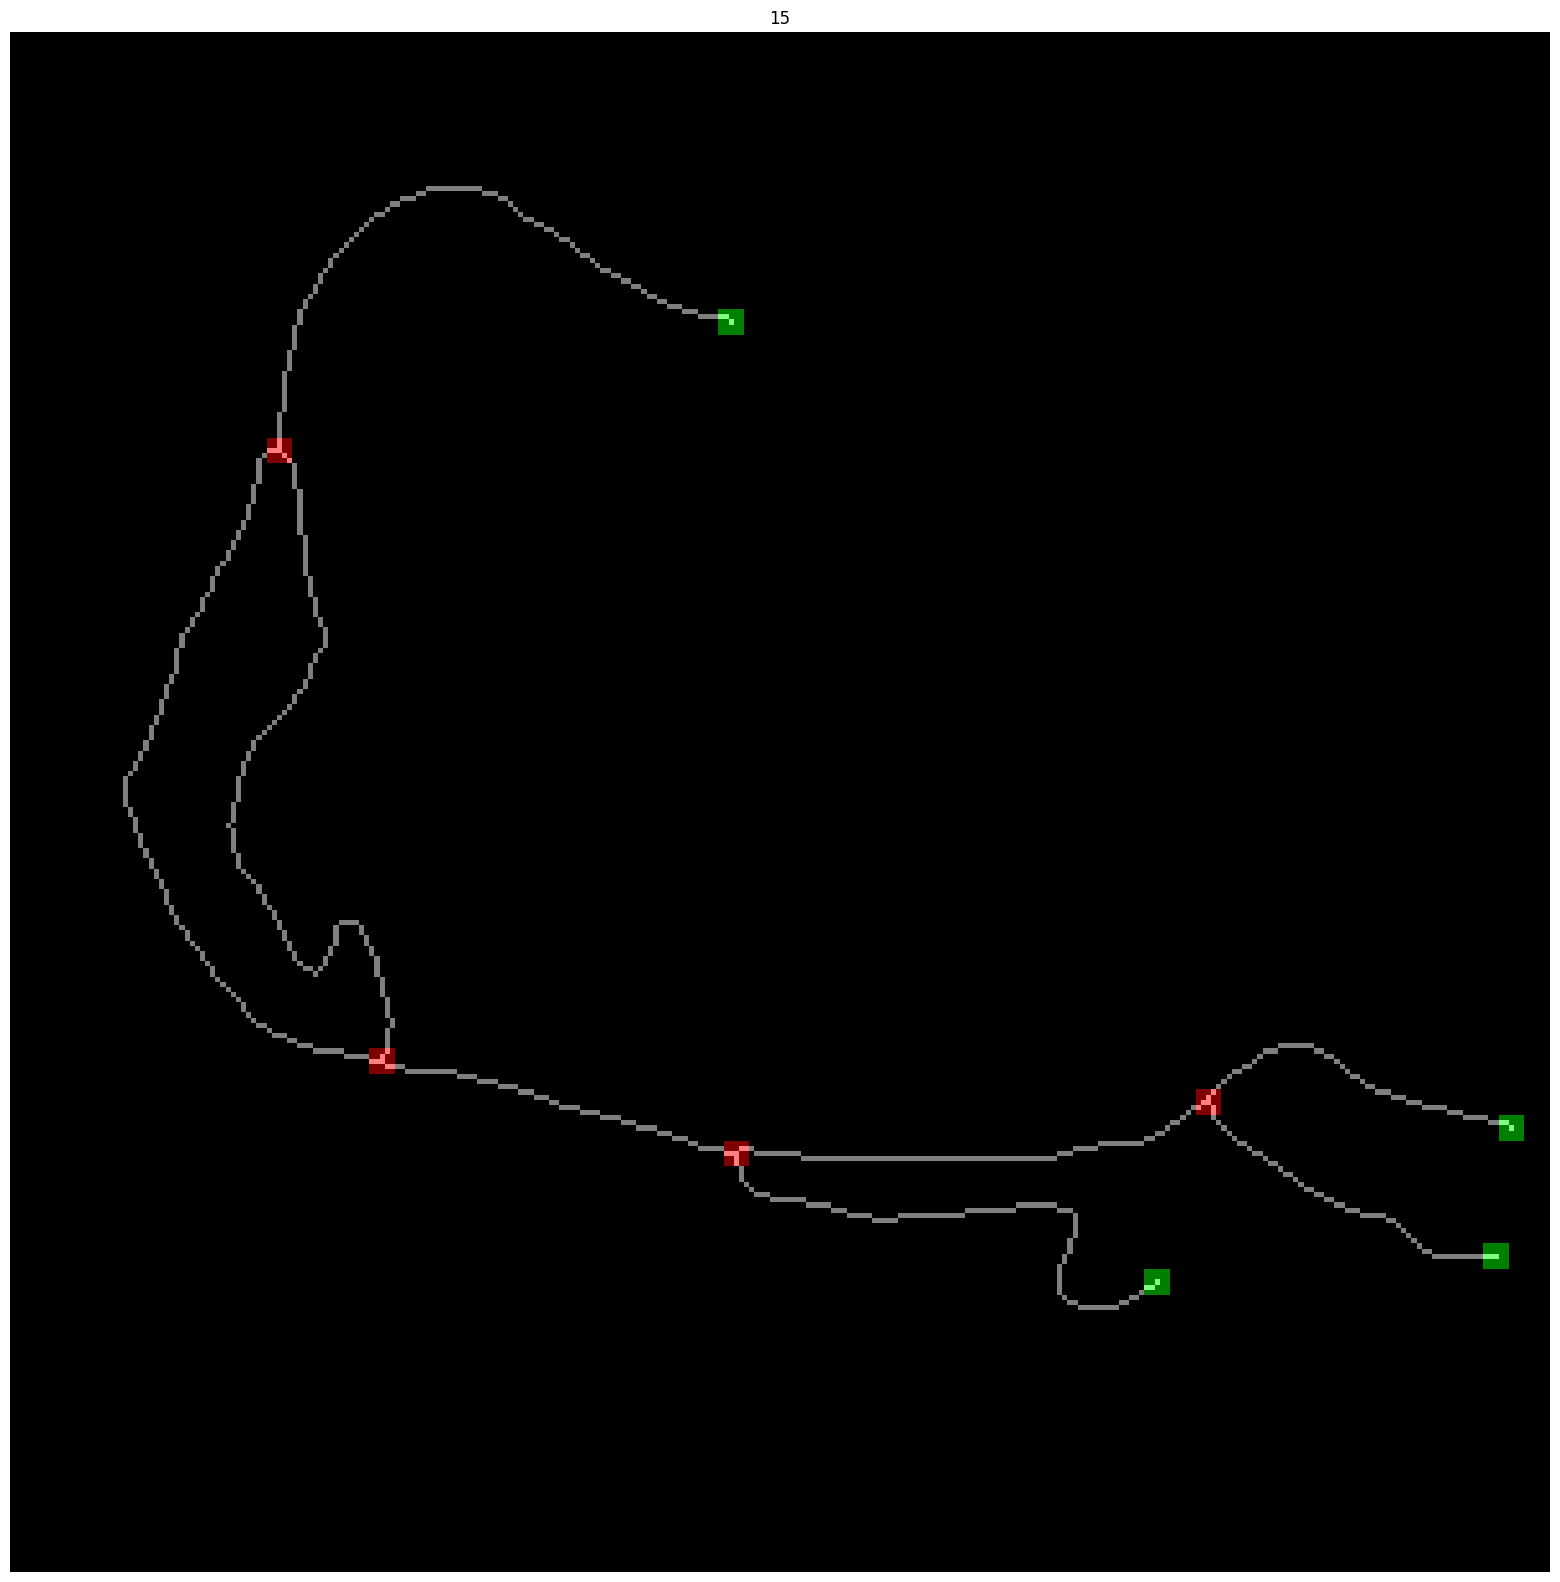

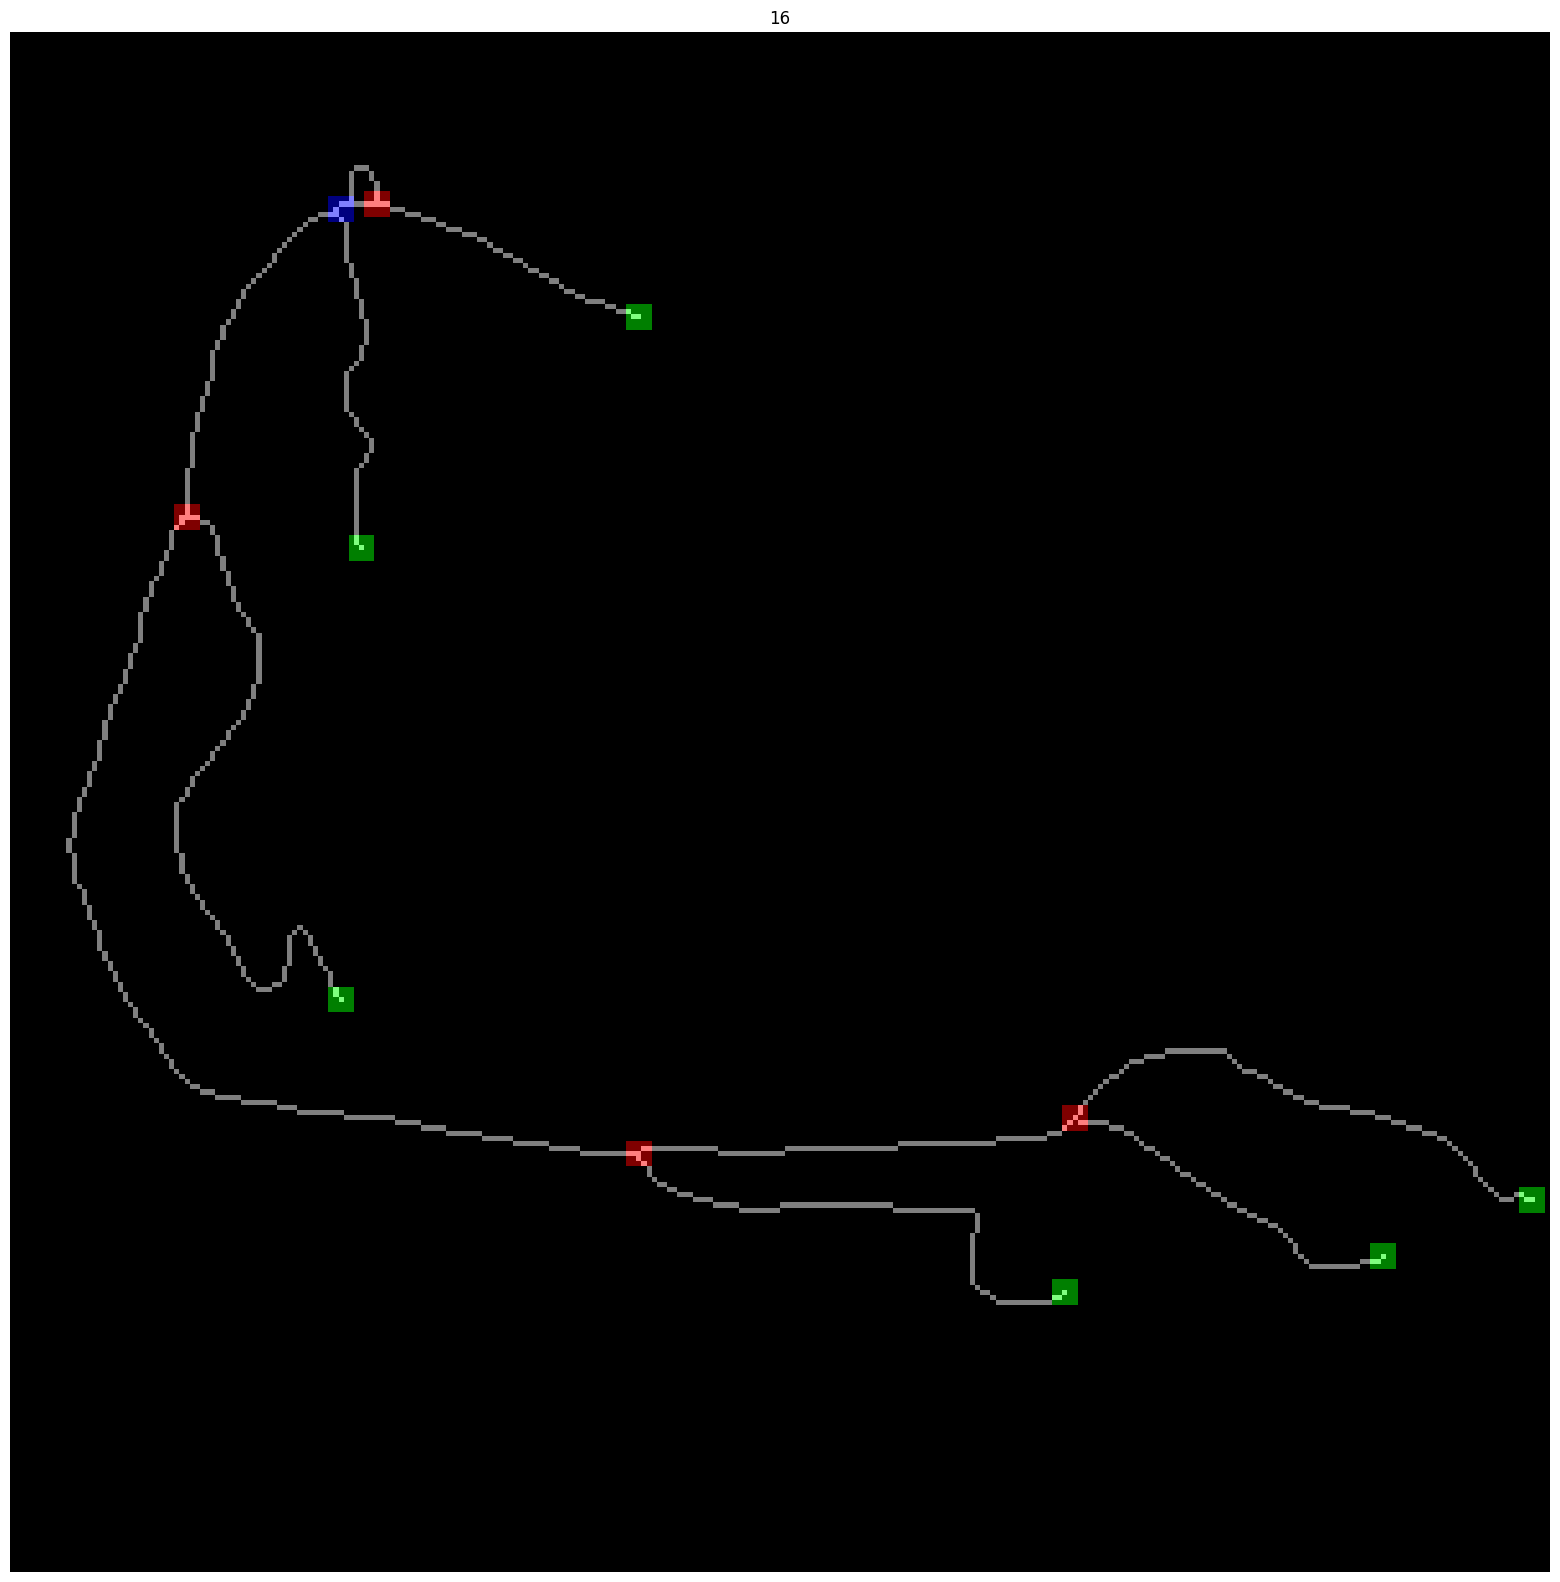

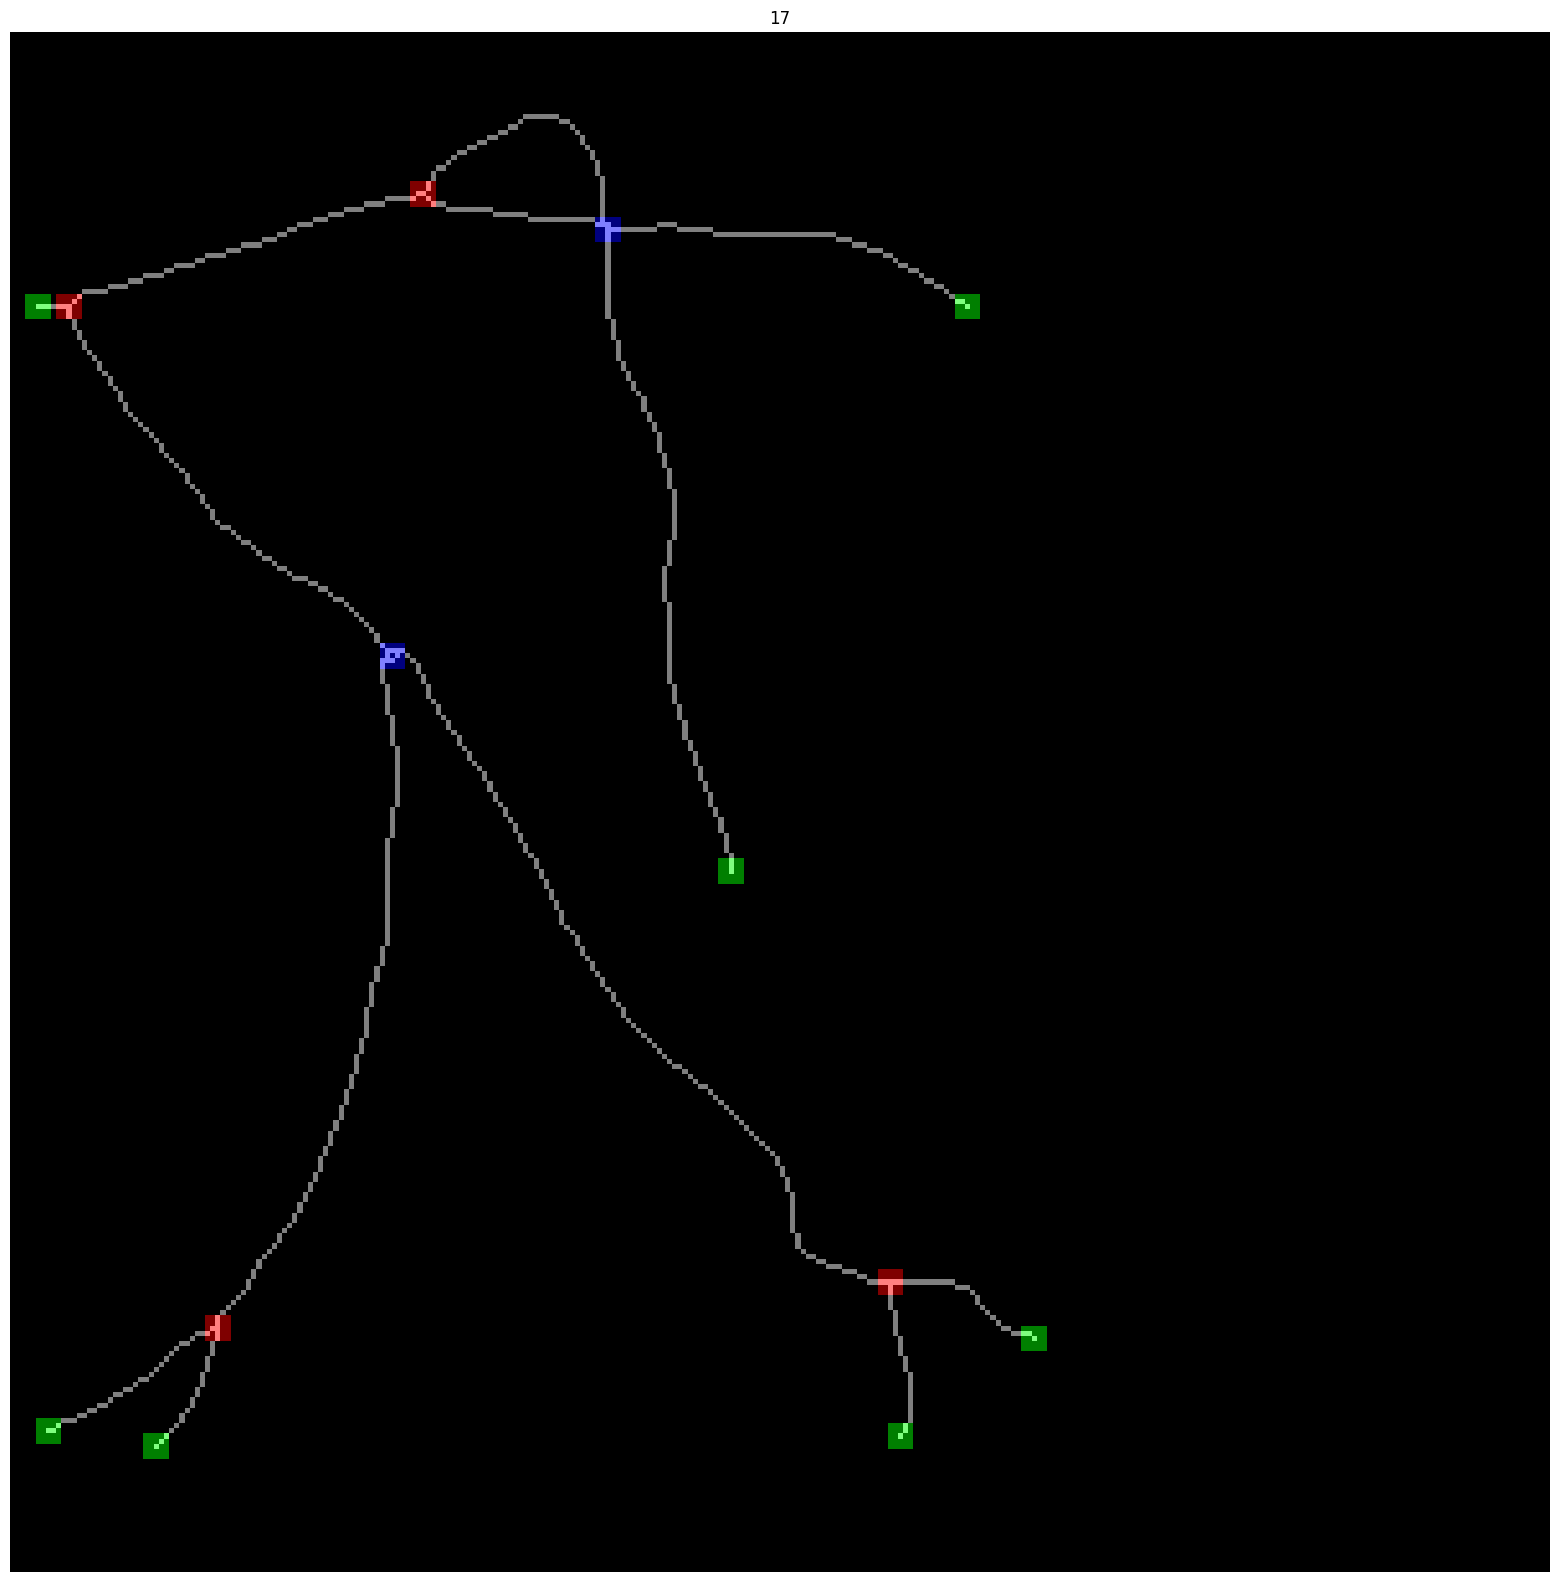

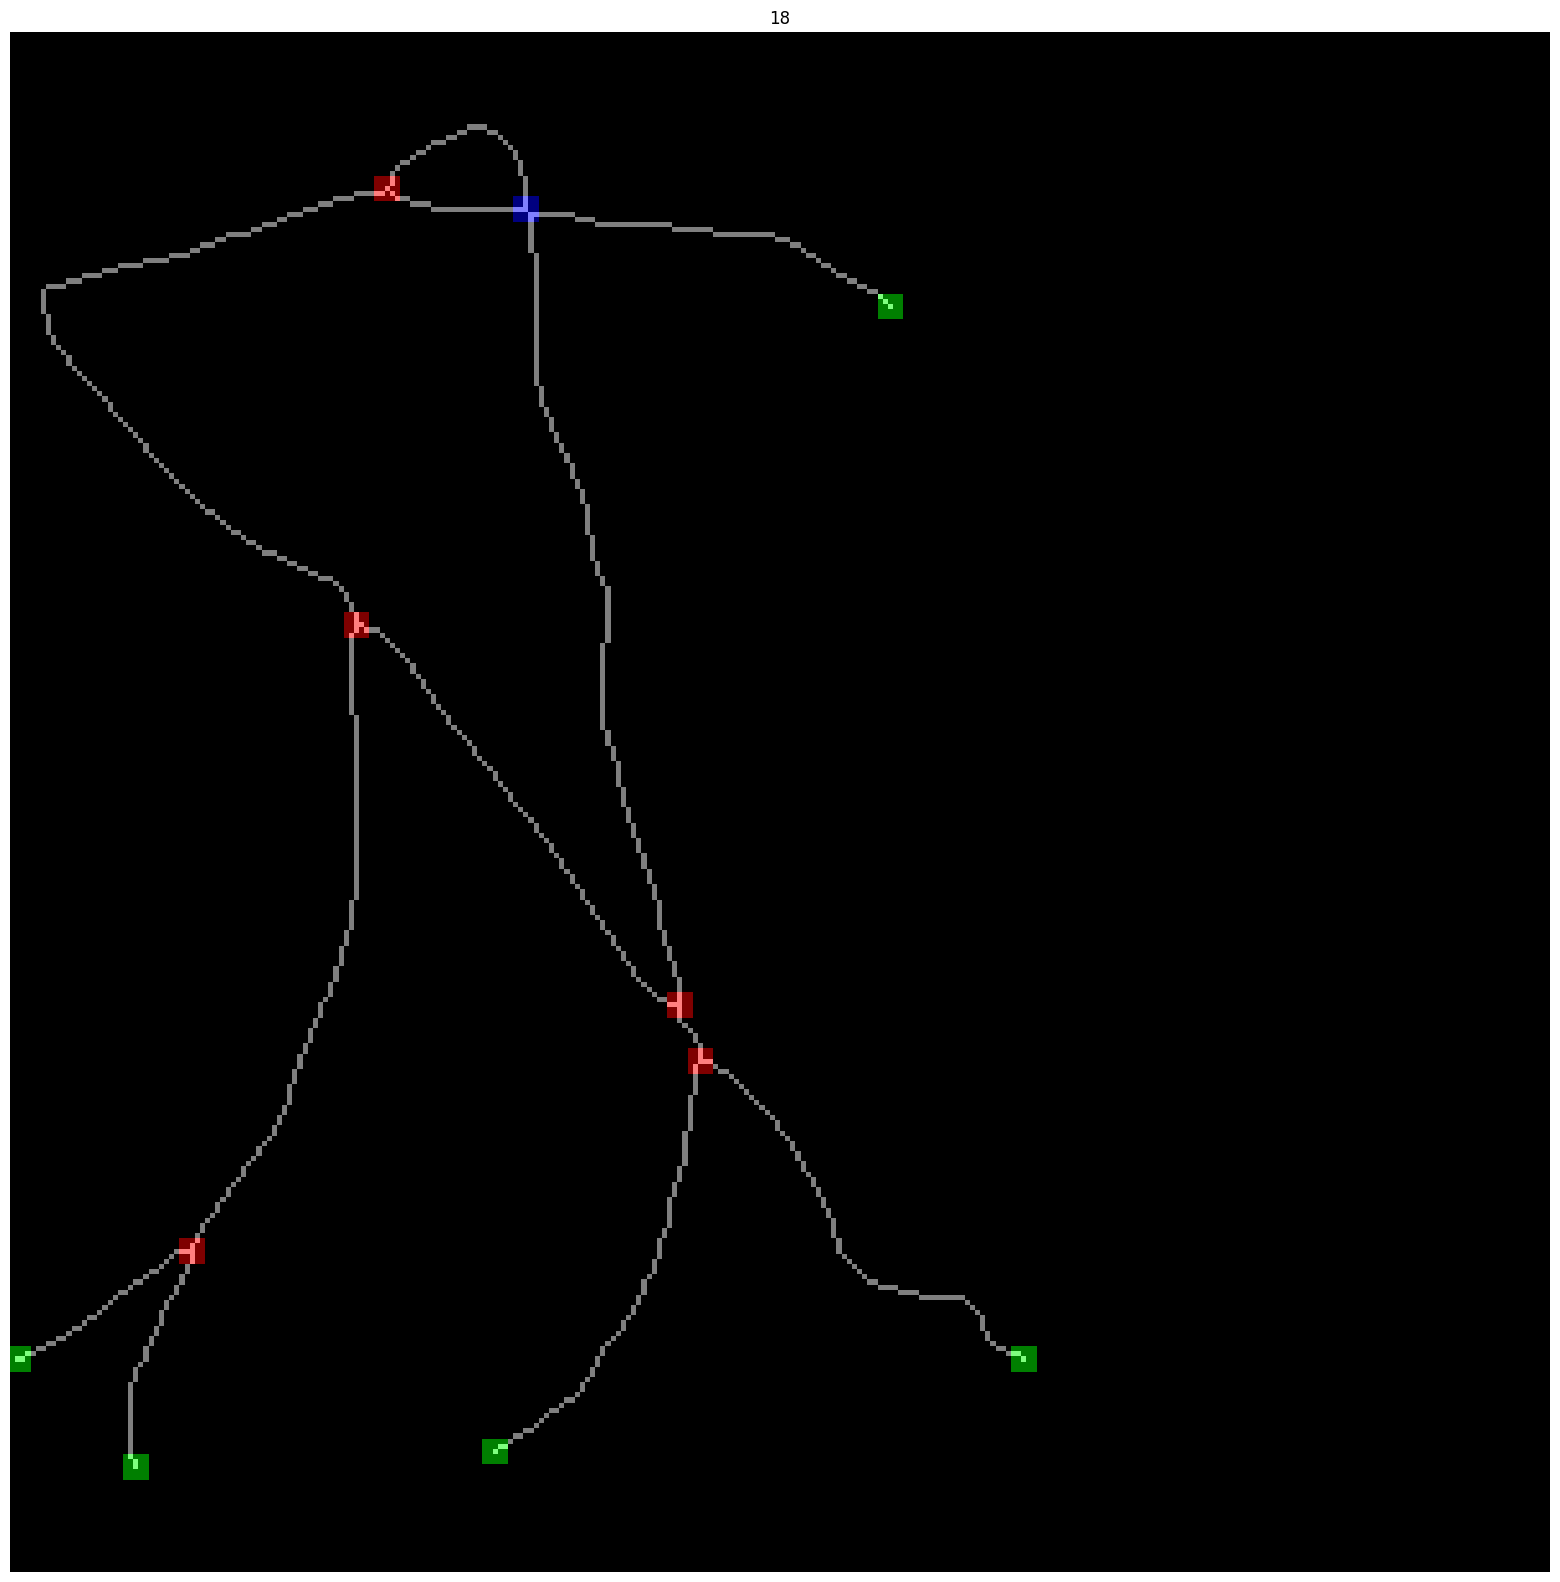

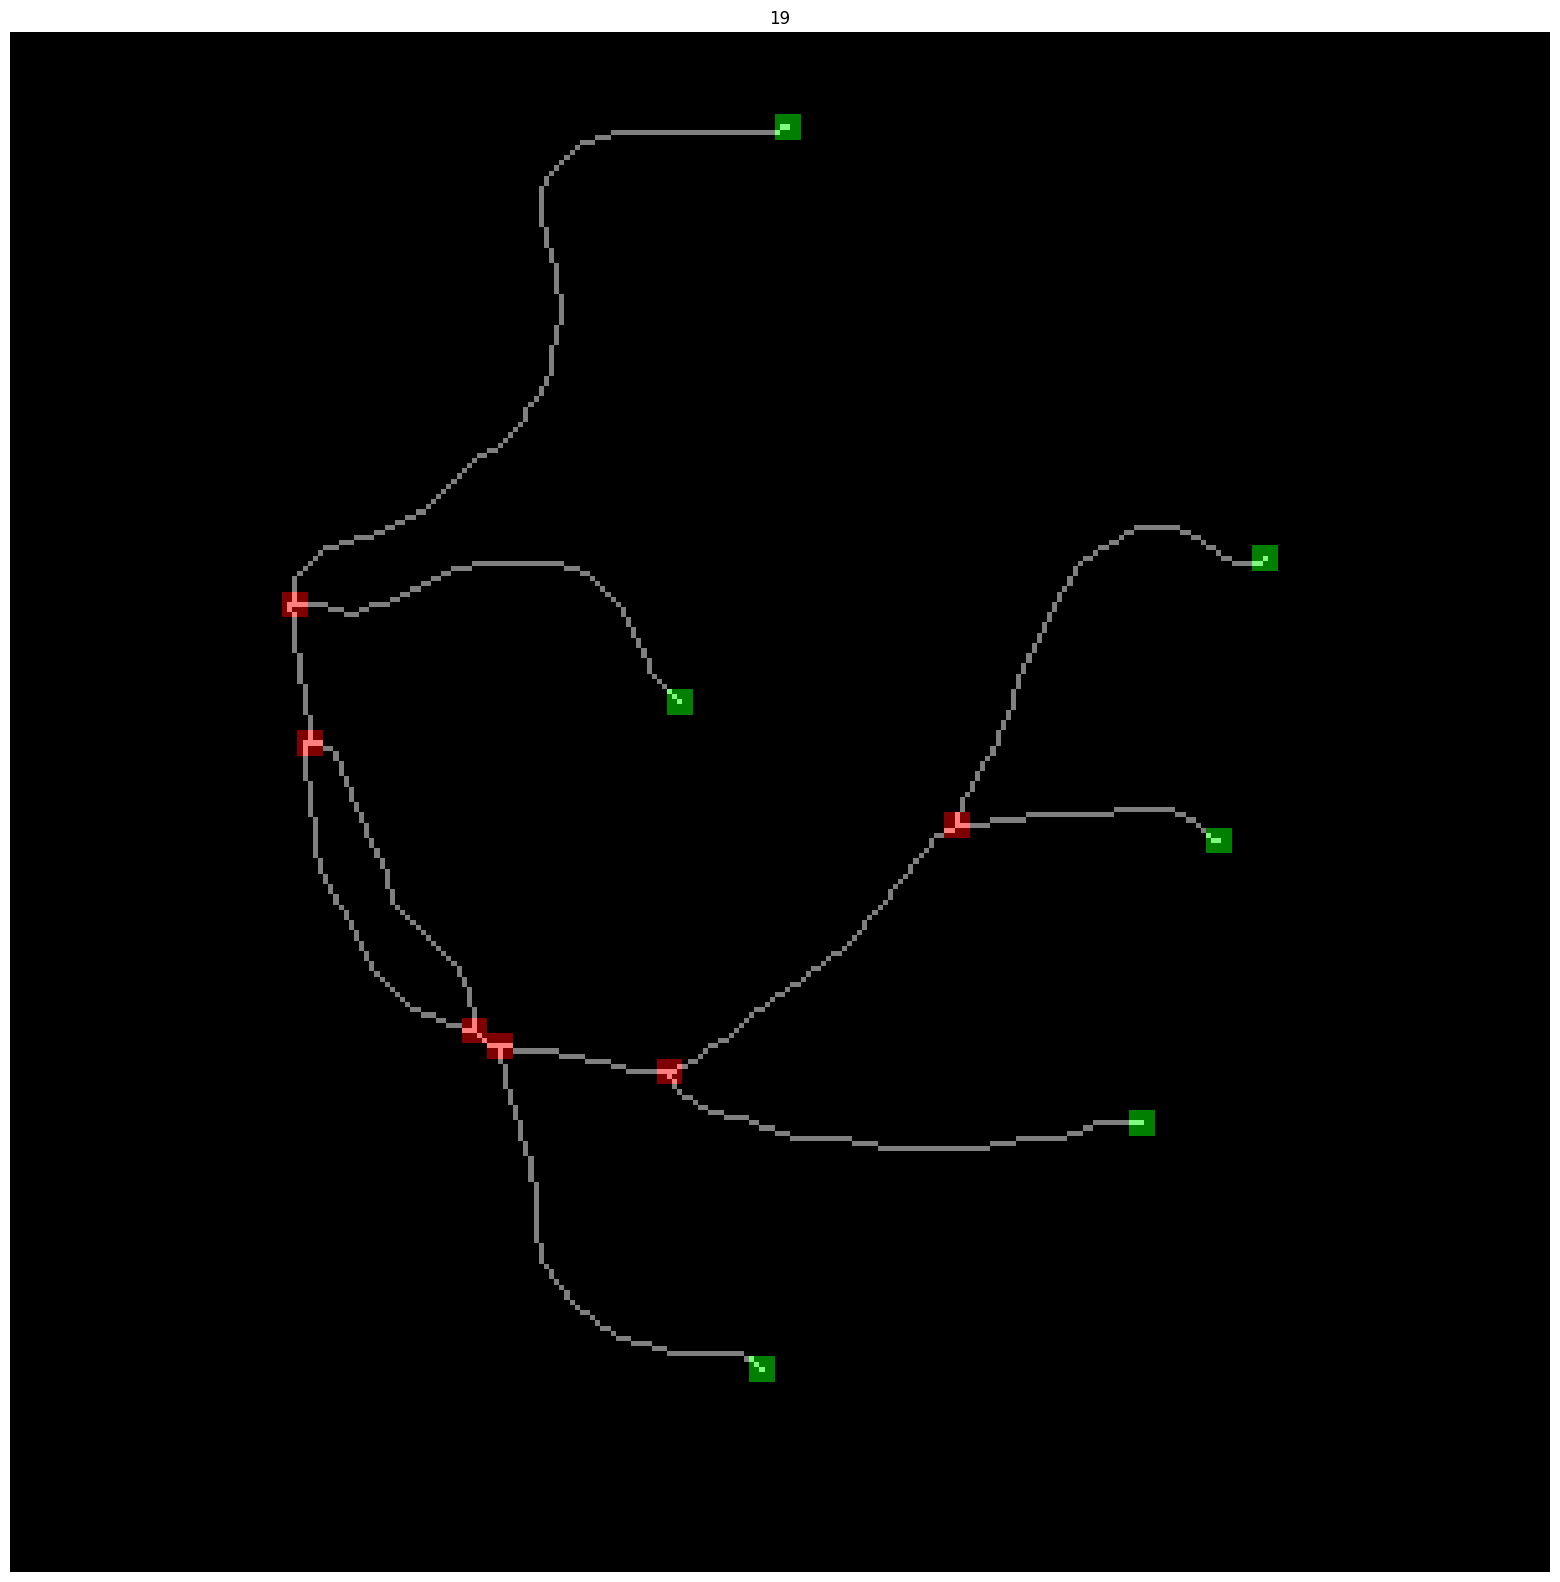

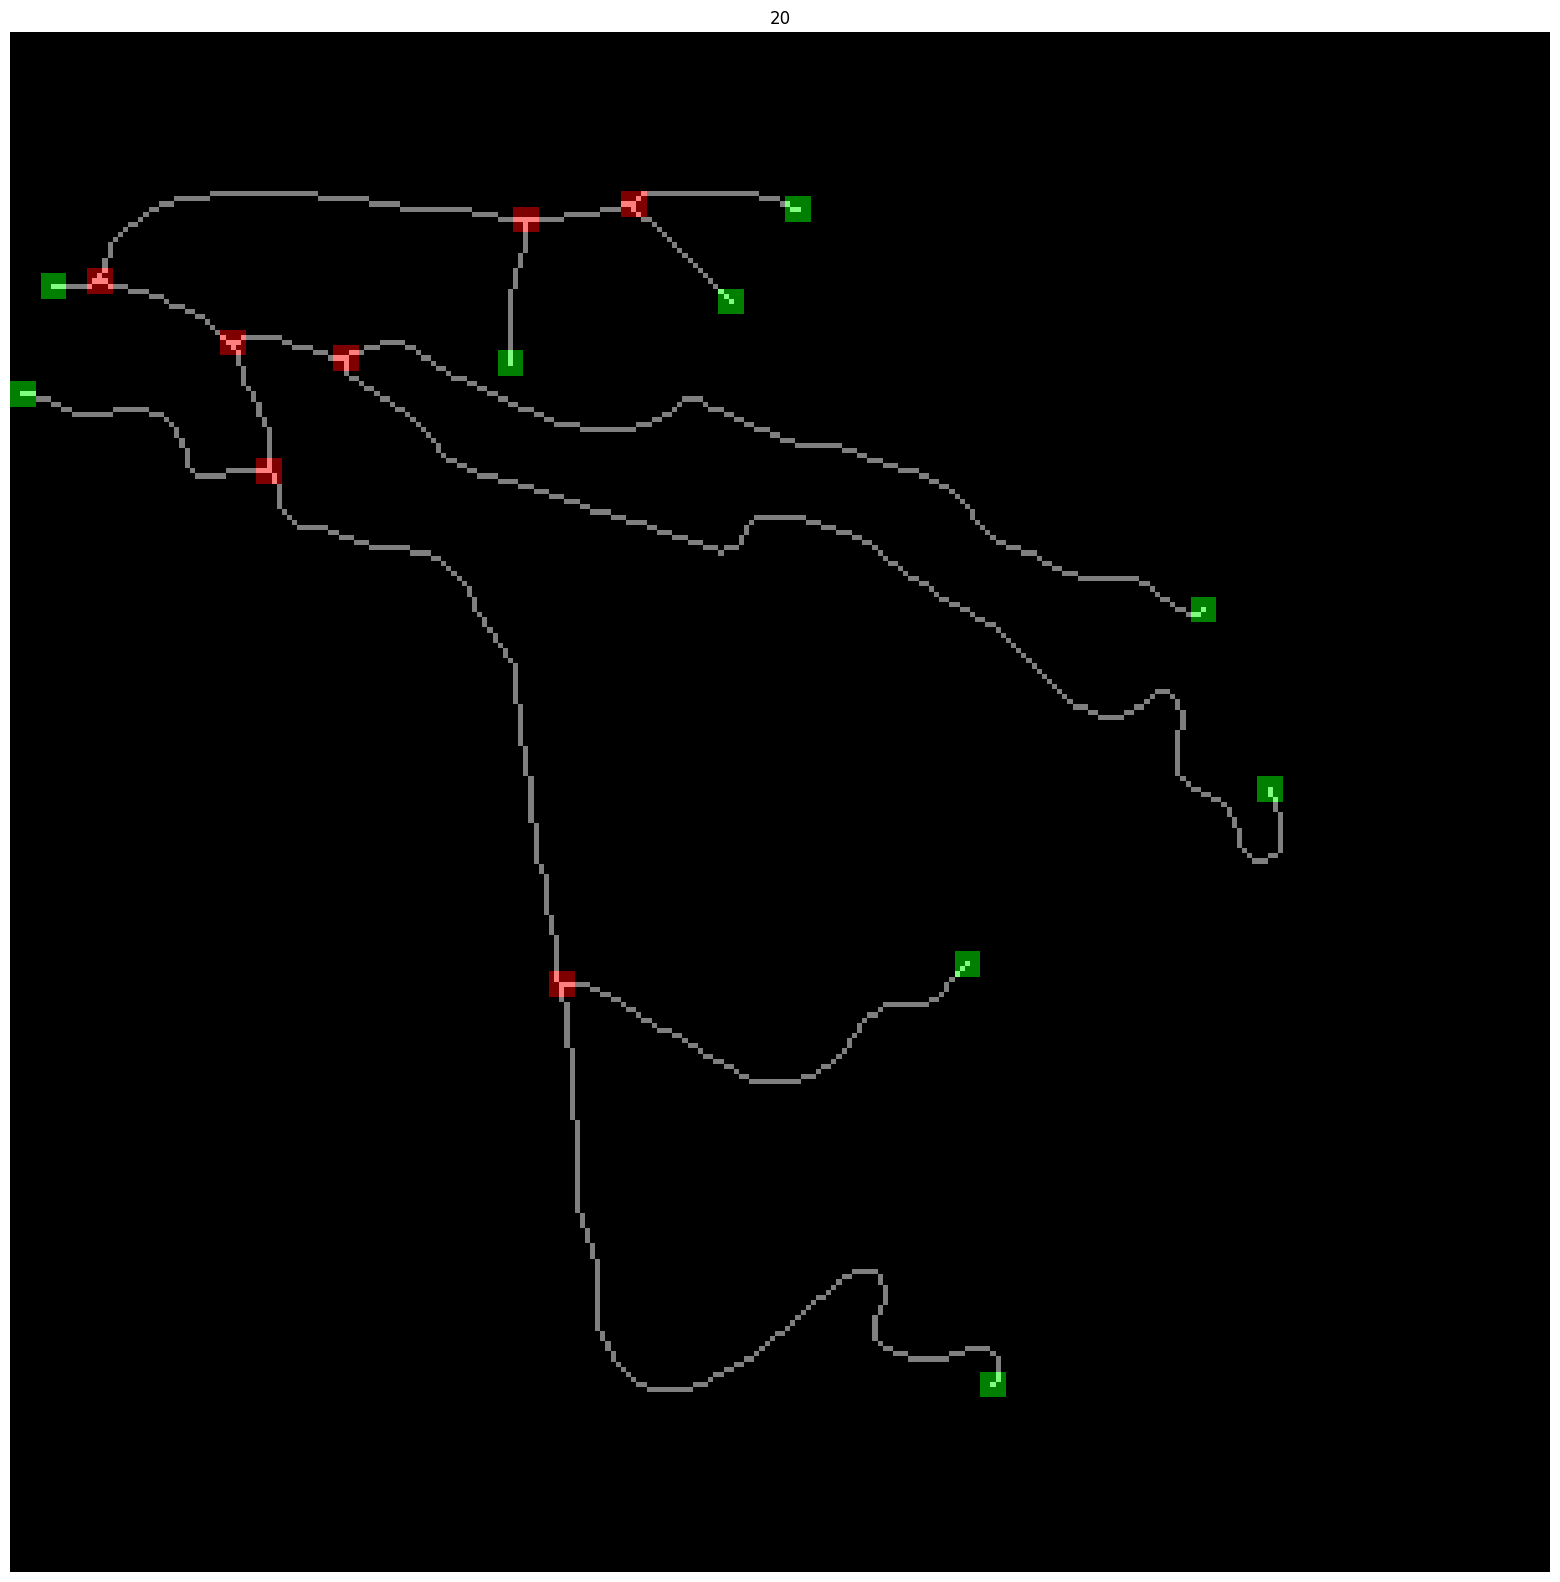

In [27]:
for i in range(1,21):
    I = plt.imread(f'database/{i}_gt.pgm')
    I = I/255
    #I = (ski.color.rgb2gray(I* 255)).astype(np.uint8)
    T = skeletonize(I)
    # Supongamos que R, G y B son imágenes en escala de grises con el mismo tamaño
    R0 = detector(T,S1) + detector(T,S2) + detector(T,S3) + detector(T,S4) # Canal Rojo
    G0 = detector(T,S1f) + detector(T,S2f)    # Canal Verde
    B0, R0 = separarDT(R0,4)
    # colocar puntos
    R = mo.dilation(R0, se3) 
    G = mo.dilation(G0, se3) 
    B = mo.dilation(B0, se3) 
    # Normalizar a rango [0,1] si es necesario
    R = R / np.max(R)
    G = G / np.max(G)
    #B = B / np.max(B)
    if np.max(B) > 1:
        B = B / np.max(B)
    R = (R+T) /2
    G = (G+T) /2
    B = (B+T) /2
    # Combinar los 3 canales en una imagen RGB
    RGB_image = np.stack((R, G, B), axis=-1)  # Shape: (100, 100, 3)
    
    # Mostrar la imagen resultante
    plt.figure(figsize=(20,20))
    plt.title(i)
    plt.imshow(RGB_image)
    plt.axis("off")  # Ocultar ejes
    plt.show()